# Conocimiento de código

## Librerías y funciones

In [283]:
import pandas as pd
import numpy as np
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from pandas.plotting import scatter_matrix
warnings.filterwarnings('ignore', category=DeprecationWarning)


def ver_Nan(df,columns):
    for column in columns:
        text = f'NaN? - {column.upper()} '
        
        isNa = df[column].isna().any()
        print(f'{text.ljust(50)} {isNa}')

def standard_scale(df):
    '''Devuelve un dataframe con las columnas escaladas'''
    scaler = StandardScaler()
    string = df.select_dtypes(include=['object']).columns #solo vamos a escalar las columnas que no son string
    df_no_string = df.drop(string,axis=1)
    df_no_string = scaler.fit_transform(df_no_string)
    df_no_string = pd.DataFrame(df_no_string,columns=df.drop(string,axis=1).columns)
    df_escaled = df.copy()
    df_escaled[df_no_string.columns] = df_no_string
    return df_escaled

def boxplot(df):
    '''Devuelve un boxplot de df'''
    df_escaled = standard_scale(df)
    sns.boxplot(data=df_escaled,orient='h')

def rango_outliers(df):
    '''Devuelve el rango de outliers de df, definidas por min y max'''
    df_escaled = standard_scale(df)
    Q1 = df_escaled.quantile(0.25)
    Q3 = df_escaled.quantile(0.75)
    IQR = Q3 - Q1
    min = Q1 - 1.5*IQR
    max = Q3 + 1.5*IQR
    return min,max

def outliers(df):
    '''Devuelve un dataframe con los outliers de df, y una columna llamada outliers con las columnas que son outliers'''
    df_escaled = standard_scale(df)
    min,max = rango_outliers(df)
    columnas_no_string = df.select_dtypes(exclude=['object']).columns
    premisa = (df_escaled[columnas_no_string] < min) | (df_escaled[columnas_no_string] > max)
    indexes = df_escaled[premisa].dropna(axis=0,how='all').index
    df_outliers_bool = df_escaled[premisa].dropna(axis=0,how='all').isna()
    df_outliers = df.loc[indexes]
    columnas = df_outliers.columns
    dict = {i:[j for j in columnas if df_outliers_bool.loc[i][j] == False] for i in indexes}
    df_outliers['outliers'] = dict.values()
    return df_outliers

def bar_plot(df,column:list):
    length = len(column)
    fig,ax = plt.subplots(1,length,figsize=(20,5))
    for i in range(length):
        #quiero qu lo string se vean en vertical
        sns.countplot(x=column[i],data=df,ax=ax[i])#los strin del eje x se solapan y no se ven, hay que rotarlos
        ax[i].tick_params(axis='x', rotation=90)


        ax[i].set_title(column[i])
        ax[i].set_ylabel('Count')
        ax[i].set_xlabel('')

def csv(predicciones,nombre,df_test):
    y_pred = pd.DataFrame({'id':df_test['id'],'Predicted':predicciones})
    y_pred['Predicted'] = y_pred['Predicted'].astype(int)
    y_pred.to_csv(nombre,index=False)

def corr_representation(train):
    ax, fig = plt.subplots(1,3,figsize=(20,5))

    corr_1 = train['Comb (L/100 km)'].corr(train['Fuel Consumption City (L/100 km)'])
    corr_2 = train['Comb (L/100 km)'].corr(train['Hwy (L/100 km)'])
    corr_3 = train['Fuel Consumption City (L/100 km)'].corr(train['Hwy (L/100 km)'])

    fig[0].scatter(train['Comb (L/100 km)'],train['Fuel Consumption City (L/100 km)'])
    fig[0].plot(np.unique(train['Comb (L/100 km)']), np.poly1d(np.polyfit(train['Comb (L/100 km)'], train['Fuel Consumption City (L/100 km)'], 1))(np.unique(train['Comb (L/100 km)'])),color='red')
    fig[0].legend([f'Correlación: {corr_1}'])

    fig[1].scatter(train['Comb (L/100 km)'],train['Hwy (L/100 km)'])
    fig[1].plot(np.unique(train['Comb (L/100 km)']), np.poly1d(np.polyfit(train['Comb (L/100 km)'], train['Hwy (L/100 km)'], 1))(np.unique(train['Comb (L/100 km)'])),color='red')
    fig[1].legend([f'Correlación: {corr_2}'])

    fig[2].scatter(train['Hwy (L/100 km)'],train['Fuel Consumption City (L/100 km)'])
    fig[2].plot(np.unique(train['Hwy (L/100 km)']), np.poly1d(np.polyfit(train['Hwy (L/100 km)'], train['Fuel Consumption City (L/100 km)'], 1))(np.unique(train['Hwy (L/100 km)'])),color='red')
    fig[2].legend([f'Correlación: {corr_3}'])


def r_2_regresion_lineal(df,x:list,y:list):
    reg = LinearRegression().fit(df[x],df[y])
    parametres = reg.coef_
    ax, fig = plt.subplots(1,3,figsize=(20,5))
    calculo = parametres[0][0]*df[x[0]] + parametres[0][1]*df[x[1]]
    r_2 = reg.score(df[x],df[y])
    fig[0].plot(df[y],calculo,color='red')
    fig[0].scatter(df[y],df[y],color='blue')
    fig[0].set_title(f'r_2: {r_2}')
    error = df['Comb (L/100 km)'] - calculo
    sns.distplot(error,ax=fig[1])

    qqplot(error,ax=fig[2],line='s')
    
    test = stats.kstest(error, 'norm')
    
    print(f'r_2: {r_2}')
    print('Test de normalidad (kolmogorov-smirnov):')
    print(test)


    


## Lectura de datos

Vamos a primero comprender los disntintos datasets que nos han facilitado el concurso. Para ello, vamos a cargar los datos y a ver qué información contienen.

In [284]:
directorio = '../apau-smog-prediction/'
lista = os.listdir(directorio)
for i in lista:
    exec(i.split('.')[0] + ' = pd.read_csv(directorio + i)')


- sample_subsimmision, ejemplo de cómo debe ser el fichero de salida (la predicción)
- test_nolabel, datos de test sin etiquetar (podemos observar que no tenemos la columna de la etiqueta -Smog-)
- train, datos de entrenamiento 



In [285]:
sample_submission.head()

,id,Predicted
0,2be023f9102,2
1,a320ba7de7b,3
2,2879e8fa078,0
3,a561b6ee65b,2
4,94c225dd8e9,1


In [286]:
test_nolabel.head()

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km)
0,2be023f9102,2022,Jeep,Wagoneer 4X4,SUV: Standard,5.7,8,A8,X,15.6,11.7,13.8,20,323
1,a320ba7de7b,2022,Porsche,718 Boxster,Two-seater,2.0,4,M6,Z,11.7,8.9,10.5,27,245
2,2879e8fa078,2022,Chrysler,Grand Caravan,Minivan,3.6,6,A9,X,12.4,8.4,10.6,27,249
3,a561b6ee65b,2022,Kia,Sorento AWD,SUV: Small,2.5,4,AM8,X,10.9,8.7,9.9,29,234
4,94c225dd8e9,2022,Bentley,Continental GT,Subcompact,4.0,8,AM8,Z,14.9,9.0,12.2,23,287


In [287]:
train.head()

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
0,ab44e9bec15,2022,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,32,202,2
1,45926762371,2022,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,37,181,4
2,e9be56e153f,2022,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,24,274,2
3,077092760df,2022,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,35,189,1
4,c1c2579b795,2022,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1


Nuestras variables son:
- Model Year: año del modelo
- Make: marca del coche
- Model: modelo del coche
- Vehicle Class: clase del vehículo
- Engine Size: tamaño del motor
- Cylinders: número de cilindros
- Transmission: tipo de transmisión
- Fuel Type: tipo de combustible
- Fuel Consumption City (L/100 km): consumo de combustible en ciudad
- Hwy (L/100 km): consumo de combustible en carretera
- Comb (L/100 km): consumo de combustible combinado
- Fuel Consumption Comb (mpg): consumo de combustible combinado (millas por galón)
- CO2 Emissions(g/km): emisiones 

## Exploración de atributos

In [288]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                586 non-null    object 
 1   Model Year                        586 non-null    int64  
 2   Make                              586 non-null    object 
 3   Model                             586 non-null    object 
 4   Vehicle Class                     586 non-null    object 
 5   Engine Size (L)                   586 non-null    float64
 6   Cylinders                         586 non-null    int64  
 7   Transmission                      586 non-null    object 
 8   Fuel Type                         586 non-null    object 
 9   Fuel Consumption City (L/100 km)  586 non-null    float64
 10  Hwy (L/100 km)                    586 non-null    float64
 11  Comb (L/100 km)                   586 non-null    float64
 12  Comb (mp

In [289]:
test_nolabel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                390 non-null    object 
 1   Model Year                        390 non-null    int64  
 2   Make                              390 non-null    object 
 3   Model                             390 non-null    object 
 4   Vehicle Class                     390 non-null    object 
 5   Engine Size (L)                   390 non-null    float64
 6   Cylinders                         390 non-null    int64  
 7   Transmission                      390 non-null    object 
 8   Fuel Type                         390 non-null    object 
 9   Fuel Consumption City (L/100 km)  390 non-null    float64
 10  Hwy (L/100 km)                    390 non-null    float64
 11  Comb (L/100 km)                   390 non-null    float64
 12  Comb (mp

### Variables categoricas

### Model Year

El atributo Model Year es un atributo numérico que representa el año del modelo del coche. 

In [290]:
test_nolabel['Model Year'].unique()

array([2022], dtype=int64)

In [291]:
train['Model Year'].unique()

array([2022], dtype=int64)

Podemos observar que los coches del dataset son modelos del año 2022. Al ser todos del mismo año, este atributo no nos aporta información y por tanto, no lo vamos a tener en cuenta en nuestro modelo.

In [292]:
train = train.drop('Model Year',axis=1)
test_nolabel = test_nolabel.drop('Model Year',axis=1)

### Make, Model y Vehicle Class

Vamos a estudiar estos tres atributos juntos, ya que los tres nos aportan información sobre el tipo de coche.
- Make: marca del coche
- Model: modelo del coche
- Vehicle Class: clase del vehículo

Se puede dar que uno de los tres atributos sea redundante, es decir, uno de ellos se pueda obtener a partir de los otros dos. Para comprobarlo, vamos a ver cuántos valores únicos tiene cada uno de ellos.

In [293]:
assert (train.groupby('Model')['Make'].nunique() == 1).all()

Como hemos visto en la celda anterior hemos demostrado que ningún modelo viene de distintas marcas, por lo que podríamos suponer
que el atributo Make es redundante. Sin embargo, no lo eliminamos ya que agrupa los modelos por marcas y puede ser interesante

### Fuel Type y Transmission

- Fuel Type: tipo de combustible
- Transmission: tipo de transmisión, que puede ser automática o manual<>

In [294]:
train['Fuel Type'].unique()

array(['Z', 'X', 'E', 'D'], dtype=object)

In [295]:
len(train)+len(test_nolabel)

976

In [296]:
train['Transmission'].unique()

array(['AM7', 'AS6', 'AM8', 'A8', 'AS8', 'M6', 'A10', 'AS10', 'A9', 'M7',
       'AV8', 'AS9', 'AV', 'AM6', 'AS7', 'AV10', 'AV7', 'A6', 'AM9', 'M5',
       'AV6', 'AS5', 'AV1'], dtype=object)

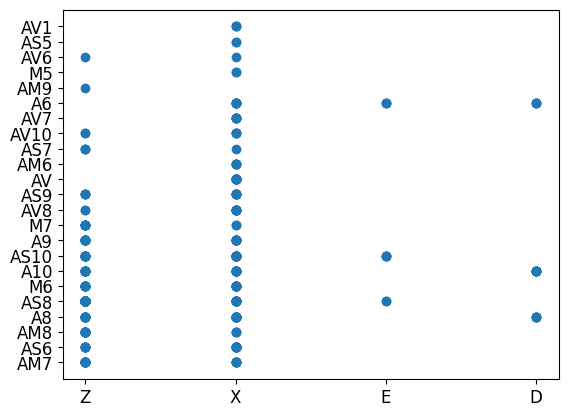

In [297]:
plt.scatter(train['Fuel Type'],train['Transmission'])

### Variables numéricas

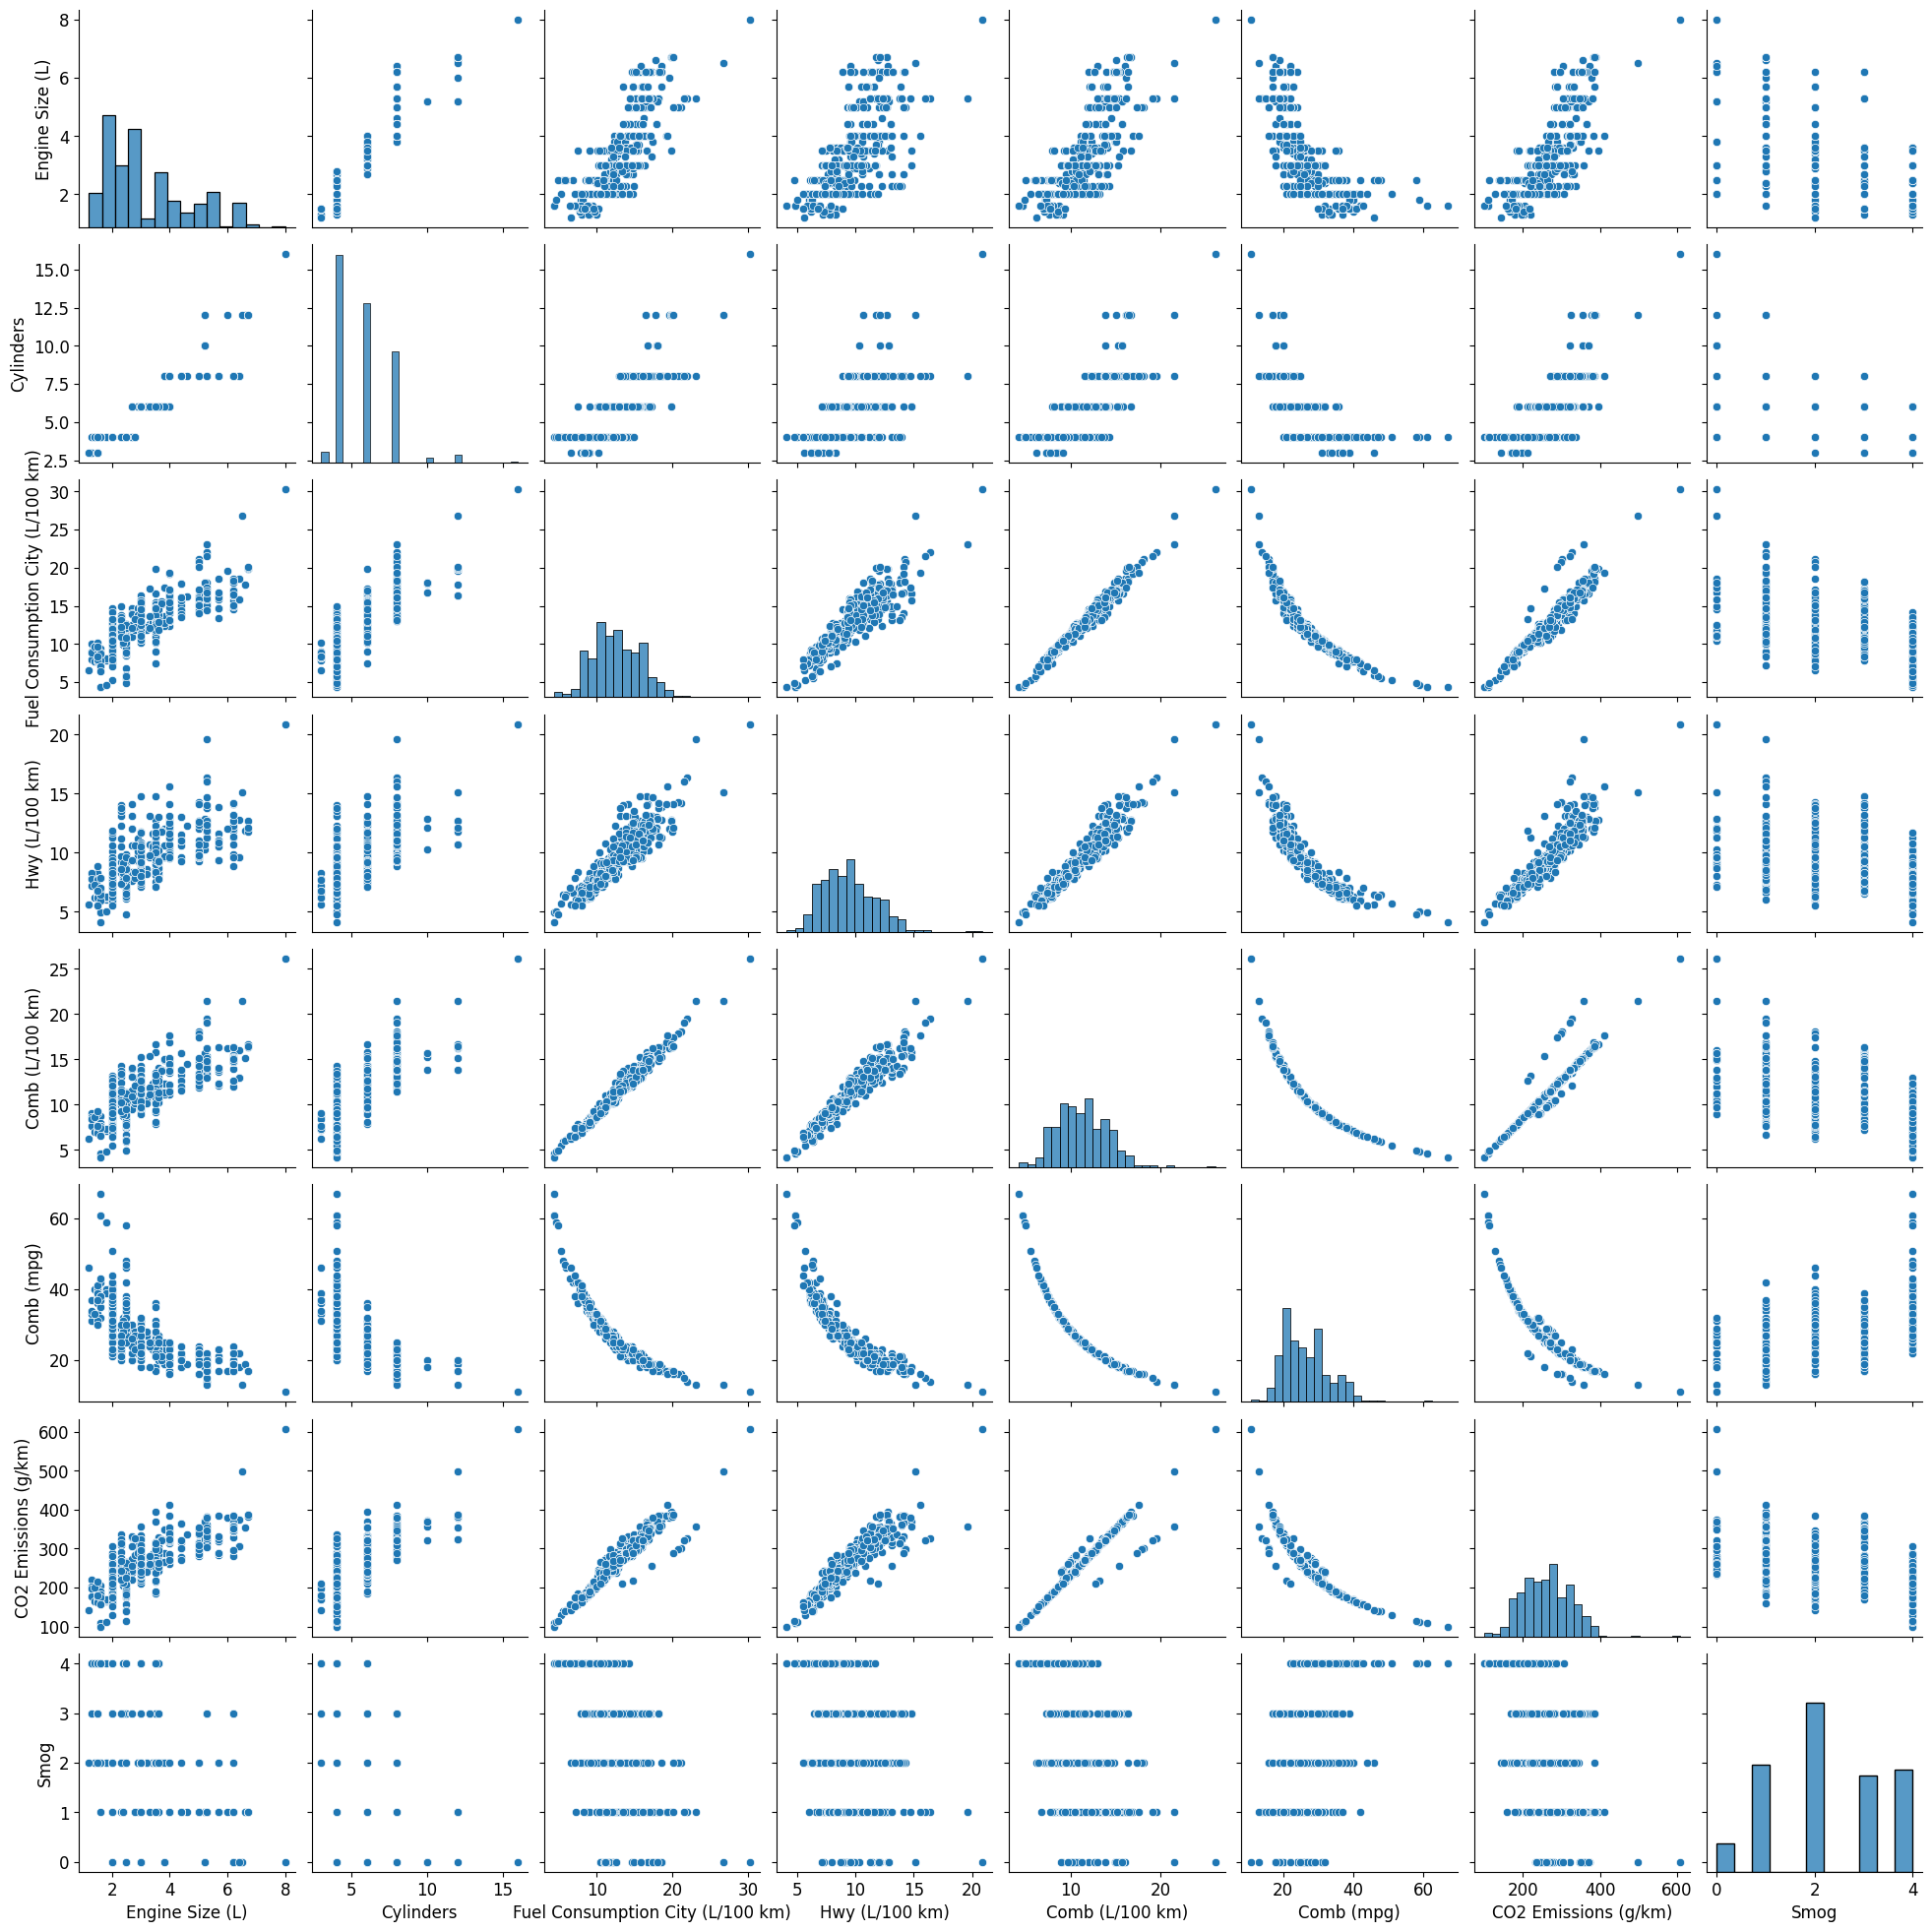

In [298]:
sns.pairplot(train)

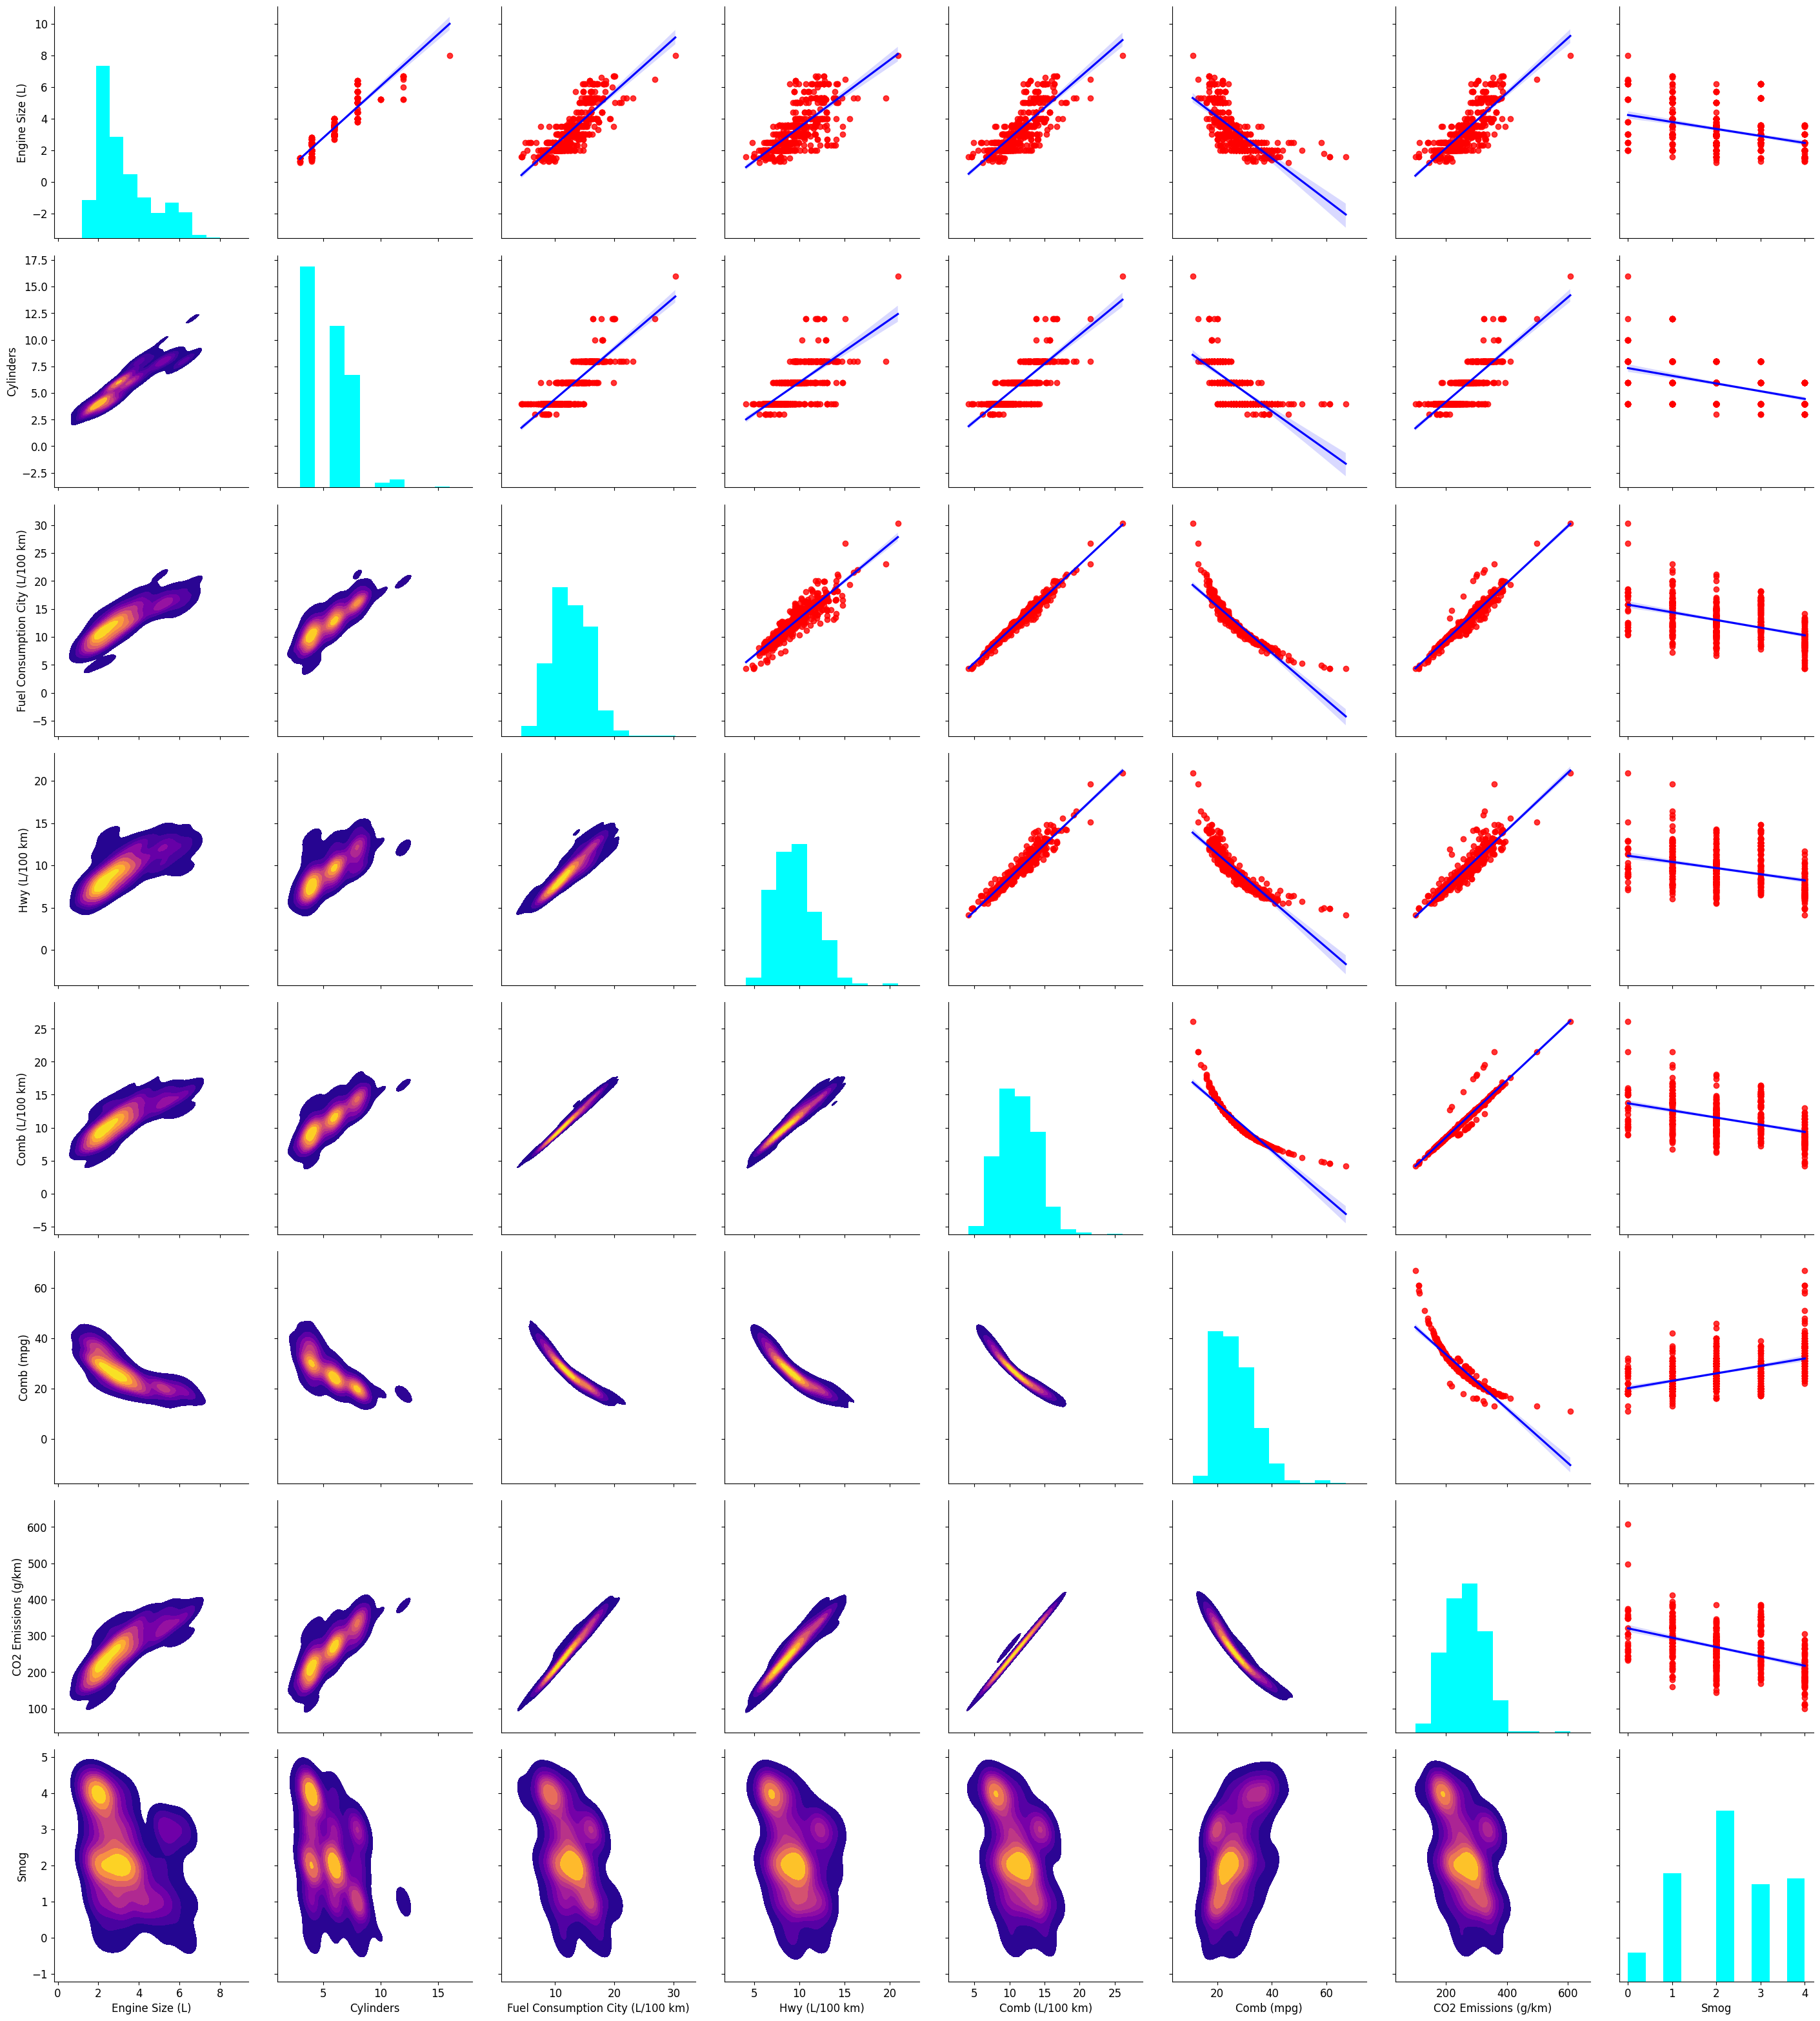

In [299]:
g = sns.PairGrid(train[columnas_numericas], height=4, aspect=0.9)
g.map_upper(sns.regplot,scatter_kws={"color": "red"}, line_kws={"color": "blue"})
g.map_lower(sns.kdeplot, cmap="plasma", shade=True, thresh=0.05)
g.map_diag(plt.hist,color = 'cyan')
plt.tight_layout
plt.show()

<Axes: >

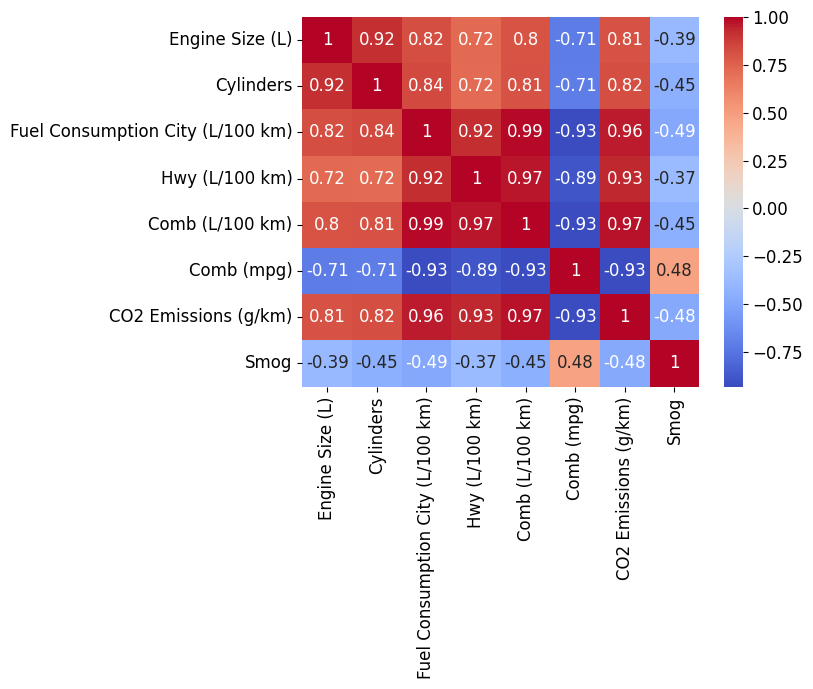

In [300]:
## mapa de calor correalación con sns
sns.heatmap(train[columnas_numericas].corr(),annot=True,cmap='coolwarm')

### Engine Size y Cylinders

- Engine Size: tamaño del motor
- Cylinders: número de cilindros


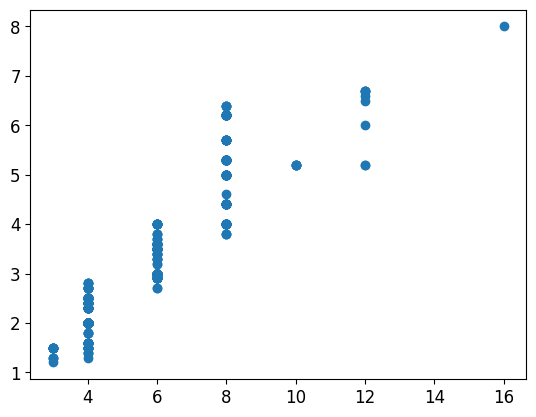

In [301]:
plt.scatter(train['Cylinders'],train['Engine Size (L)'])

In [302]:
train.head()

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
0,ab44e9bec15,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,32,202,2
1,45926762371,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,37,181,4
2,e9be56e153f,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,24,274,2
3,077092760df,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,35,189,1
4,c1c2579b795,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1


### Fuel Consumption City,  Hwy, Comb (L/100 km), Comb (mpg) y CO2 Emissions

- Fuel Consumption City (L/100 km): consumo de combustible en ciudad
- Hwy (L/100 km): consumo de combustible en carretera
- Comb (L/100 km): consumo de combustible combinado
- Comb (mpg): consumo de combustible combinado (millas por galón)
- CO2 Emissions(g/km): emisiones

#### Comb (mpg) y Comb (L/100 km)

Podemos observar de primeras que tenemos dos atributos que nos dan la misma información, pero en distintas unidades. Estos son Comb (L/100 km) y Comb (mpg). 

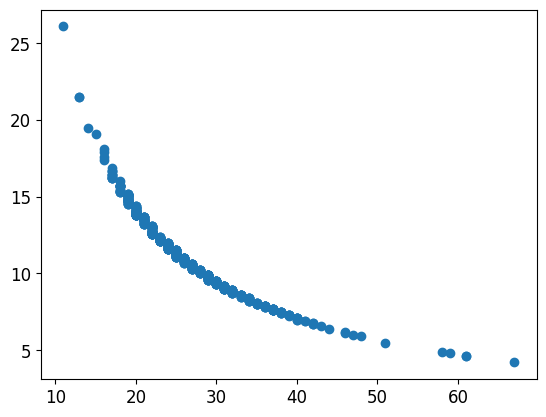

In [303]:
#representamos en un plot la relacion entre las variables comb (L/100 km) y comb (mpg)
plt.scatter(train['Comb (mpg)'],train['Comb (L/100 km)'])

Para pasar de millas por galón a litros por 100 km, vamos a utilizar la siguiente fórmula:
- 1 L/100Km = 282 /mpgImperial

In [304]:
train[['Comb (mpg)','Comb (L/100 km)']].head()

,Comb (mpg),Comb (L/100 km)
0,32,8.7
1,37,7.7
2,24,11.7
3,35,8.1
4,20,13.8


Text(0.5, 1.0, 'Comb (mpg) (redondeado) vs Comb (L/100 km)')

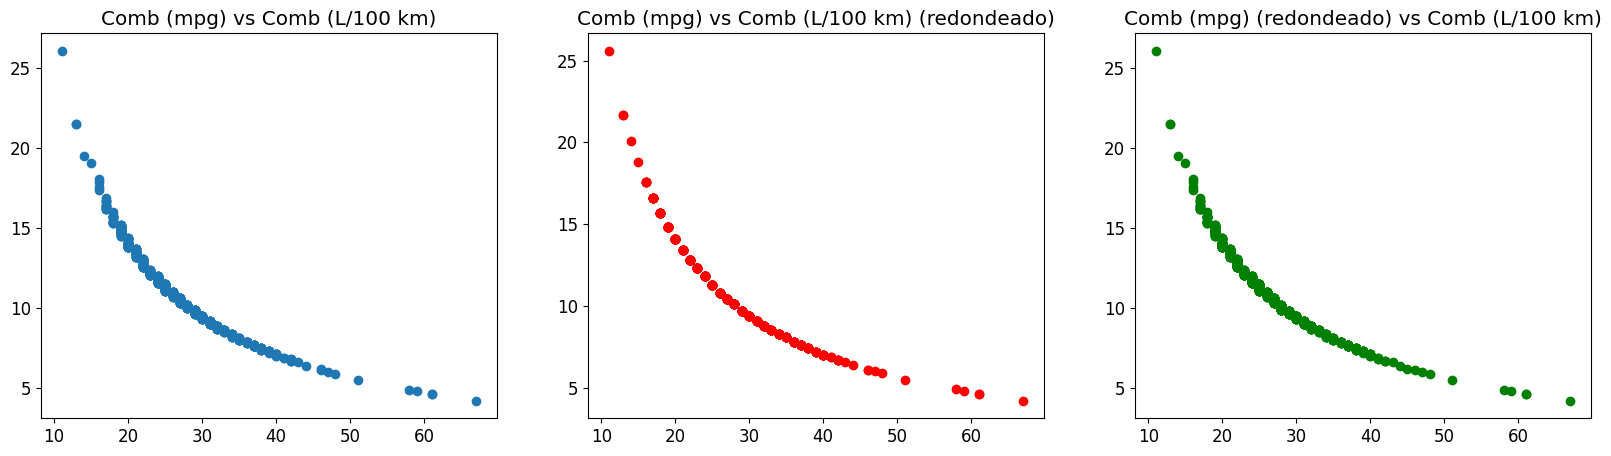

In [305]:
ax,fig = plt.subplots(1,3,figsize=(20,5))

fig[0].scatter(train['Comb (mpg)'],train['Comb (L/100 km)'])
fig[0].set_title('Comb (mpg) vs Comb (L/100 km)')

fig[1].scatter(train['Comb (mpg)'],np.around(282/train['Comb (mpg)'],1),color='red')
fig[1].set_title('Comb (mpg) vs Comb (L/100 km) (redondeado)')

fig[2].scatter(np.around(282/train['Comb (L/100 km)']),train['Comb (L/100 km)'],color='green')
fig[2].set_title('Comb (mpg) (redondeado) vs Comb (L/100 km)')


Text(0.5, 1.0, 'Error redondeo mpg')

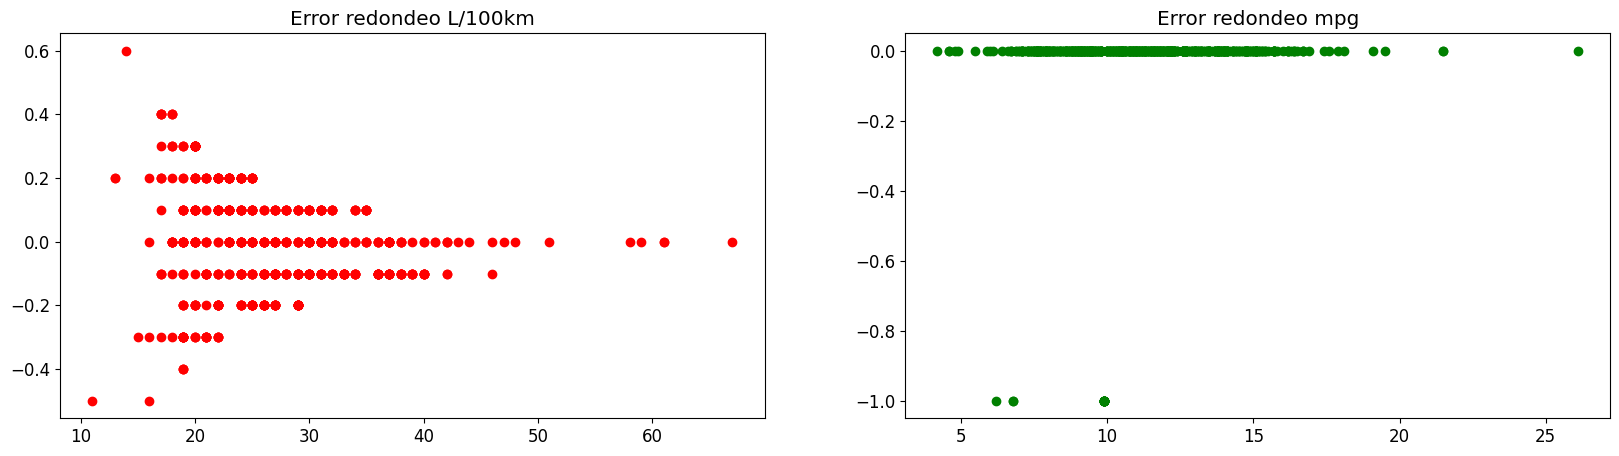

In [306]:

error_redonde_km = np.around(282/train['Comb (mpg)'],1) - train['Comb (L/100 km)']
error_redondeo_mpg = np.around(282/train['Comb (L/100 km)']) - train['Comb (mpg)']

ax, fig = plt.subplots(1,2,figsize=(20,5))


fig[0].scatter(train['Comb (mpg)'],error_redonde_km,color='red')
fig[0].set_title('Error redondeo L/100km')

fig[1].scatter(train['Comb (L/100 km)'],error_redondeo_mpg,color='green')
fig[1].set_title('Error redondeo mpg')


Podemos observar claramente que el atributo Comb (mpg) está calculado a partir de Comb (L/100 km), por lo que podemos eliminarlo. En cuanto a esos outliers de error que son -1, se deben a un error de redondeo en el dataset original

In [307]:
copy = train.copy()
copy['error_redondeo_mpg'] = error_redondeo_mpg

outliers_error = copy[copy['error_redondeo_mpg'] < -0.5]
outliers_error = outliers_error[['Comb (mpg)','Comb (L/100 km)','error_redondeo_mpg']]

In [308]:
outliers_error['calculo_mpg_sin_rendondeo']= 282/outliers_error['Comb (L/100 km)']

In [309]:
outliers_error

,Comb (mpg),Comb (L/100 km),error_redondeo_mpg,calculo_mpg_sin_rendondeo
45,29,9.9,-1.0,28.484848
60,42,6.8,-1.0,41.470588
81,29,9.9,-1.0,28.484848
82,29,9.9,-1.0,28.484848
141,29,9.9,-1.0,28.484848
210,29,9.9,-1.0,28.484848
351,29,9.9,-1.0,28.484848
380,29,9.9,-1.0,28.484848
420,29,9.9,-1.0,28.484848
424,29,9.9,-1.0,28.484848


Text(0.5, 1.0, 'Error redondeo mpg')

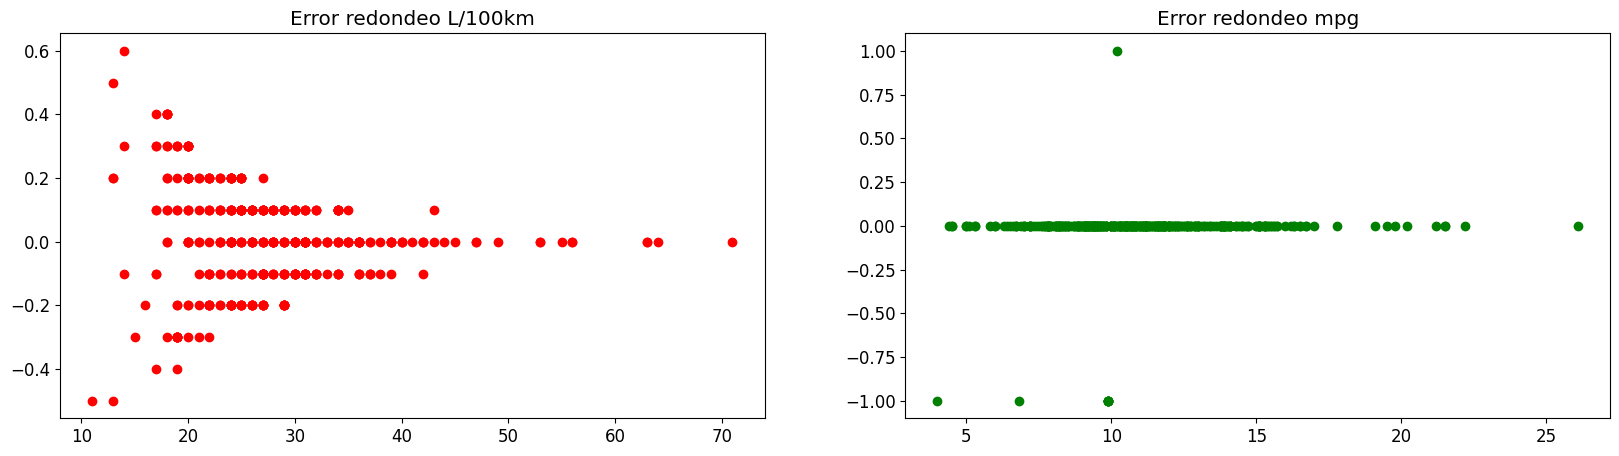

In [310]:

error_redonde_km = np.around(282/test_nolabel['Comb (mpg)'],1) - test_nolabel['Comb (L/100 km)']
error_redondeo_mpg = np.around(282/test_nolabel['Comb (L/100 km)']) - test_nolabel['Comb (mpg)']

ax, fig = plt.subplots(1,2,figsize=(20,5))


fig[0].scatter(test_nolabel['Comb (mpg)'],error_redonde_km,color='red')
fig[0].set_title('Error redondeo L/100km')

fig[1].scatter(test_nolabel['Comb (L/100 km)'],error_redondeo_mpg,color='green')
fig[1].set_title('Error redondeo mpg')

Lo mismo observamos en test pero además se le añaden los errores +1, es decir, ha redondeado hacia abajo el dataset original cuando debería haber redondeado hacia arriba.

In [311]:
copy = test_nolabel.copy()
copy['error_redondeo_mpg'] = error_redondeo_mpg
premisa = (copy['error_redondeo_mpg'] < -0.5) | (copy['error_redondeo_mpg'] > 0.5)
outliers_error = copy[premisa]
outliers_error = outliers_error[['Comb (mpg)','Comb (L/100 km)','error_redondeo_mpg']]
outliers_error['calculo_mpg_sin_rendondeo']= 282/outliers_error['Comb (L/100 km)']
outliers_error

,Comb (mpg),Comb (L/100 km),error_redondeo_mpg,calculo_mpg_sin_rendondeo
3,29,9.9,-1.0,28.484848
15,29,9.9,-1.0,28.484848
31,27,10.2,1.0,27.647059
35,71,4.0,-1.0,70.500000
58,29,9.9,-1.0,28.484848
62,29,9.9,-1.0,28.484848
101,42,6.8,-1.0,41.470588
238,29,9.9,-1.0,28.484848
296,29,9.9,-1.0,28.484848


In [312]:
train = train.drop('Comb (mpg)',axis=1)
test_nolabel = test_nolabel.drop('Comb (mpg)',axis=1)

#### Fuel Consumption City (L/100 km) , Hwy (L/100 km) y Comb (L/100 km)

Ya que uno hace referencia al consumo en ciudad, otro al consumo en carretera y el último al consumo combinado, podemos sacar información de los tres.

In [313]:
train.head()

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog
0,ab44e9bec15,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,202,2
1,45926762371,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,181,4
2,e9be56e153f,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,274,2
3,077092760df,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,189,1
4,c1c2579b795,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,324,1


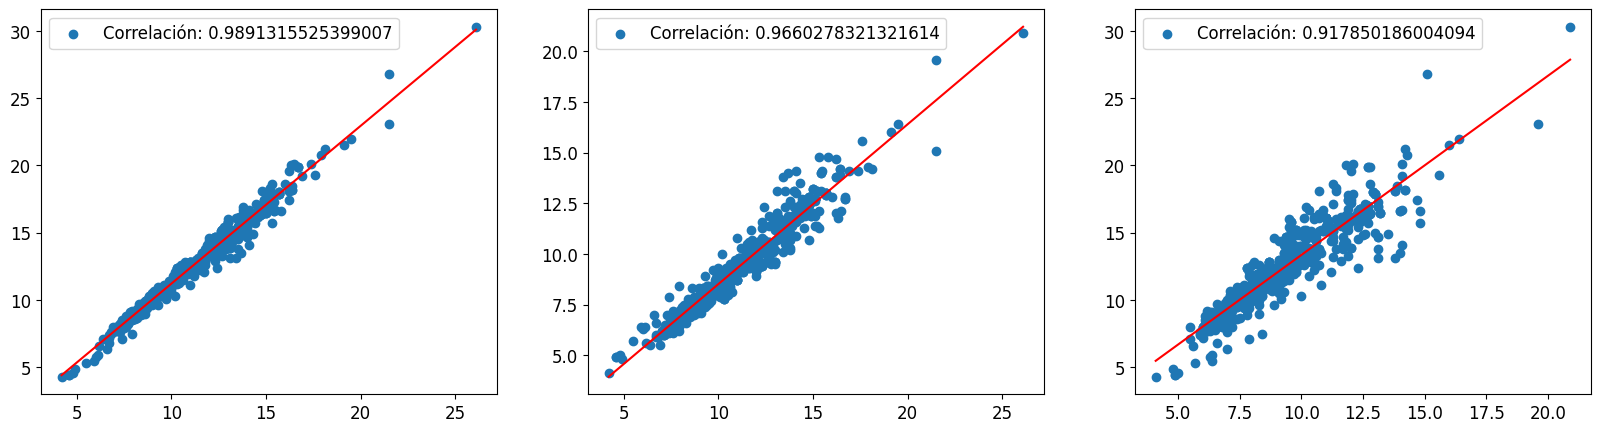

In [314]:
corr_representation(train)


Por las gráficas podemos observar que hay una correlación lineal entres los tres atributos, por lo que podríamos eliminar alguno de ellos. Sin embargo, no lo vamos hacer ya que nos pueden aportar información que nos ayude a predecir mejor.
Aún así dicha correlación la podemos usar para los outliers, es decir, sustituir los valores de los outliers por el calculado a partir de la correlación lineal. 

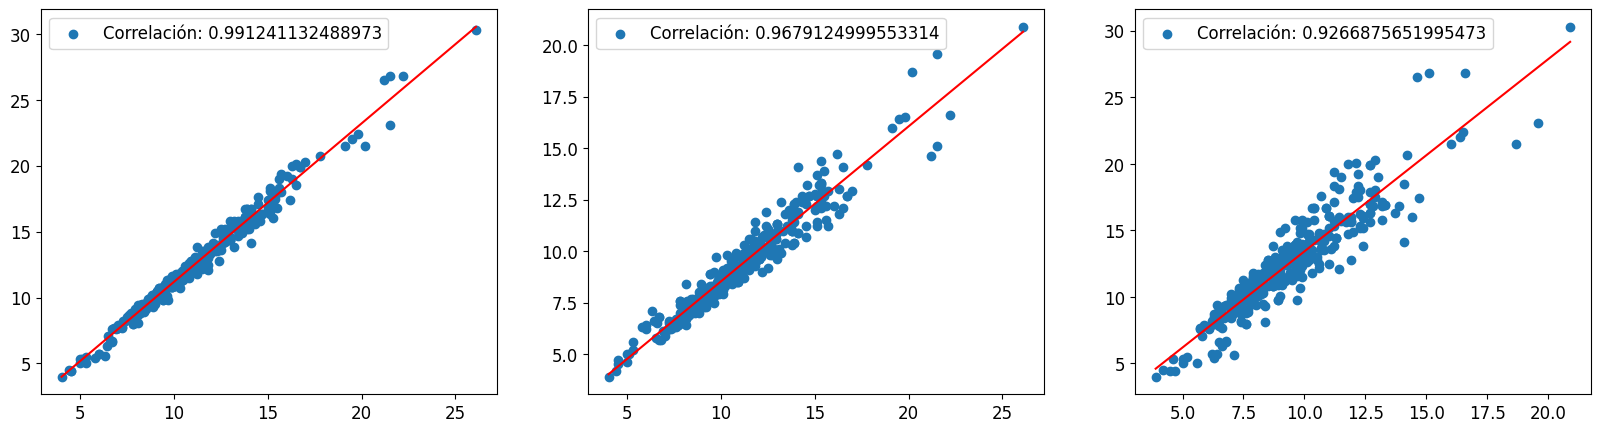

In [315]:
corr_representation(test_nolabel)

En el test encontramos la misma correlación lineal entre los diferentes atributos

Como hemos observado existe una correlación lineal entre los tres atributos. Vamos a estudiar una regresión lineal para ver si podemos predecir el consumo combinado a partir del consumo en ciudad y en carretera.

r_2: 0.999846023883621
Test de normalidad (kolmogorov-smirnov):
KstestResult(statistic=0.46989132547935175, pvalue=3.4152965448109427e-119, statistic_location=0.07554304429902103, statistic_sign=1)


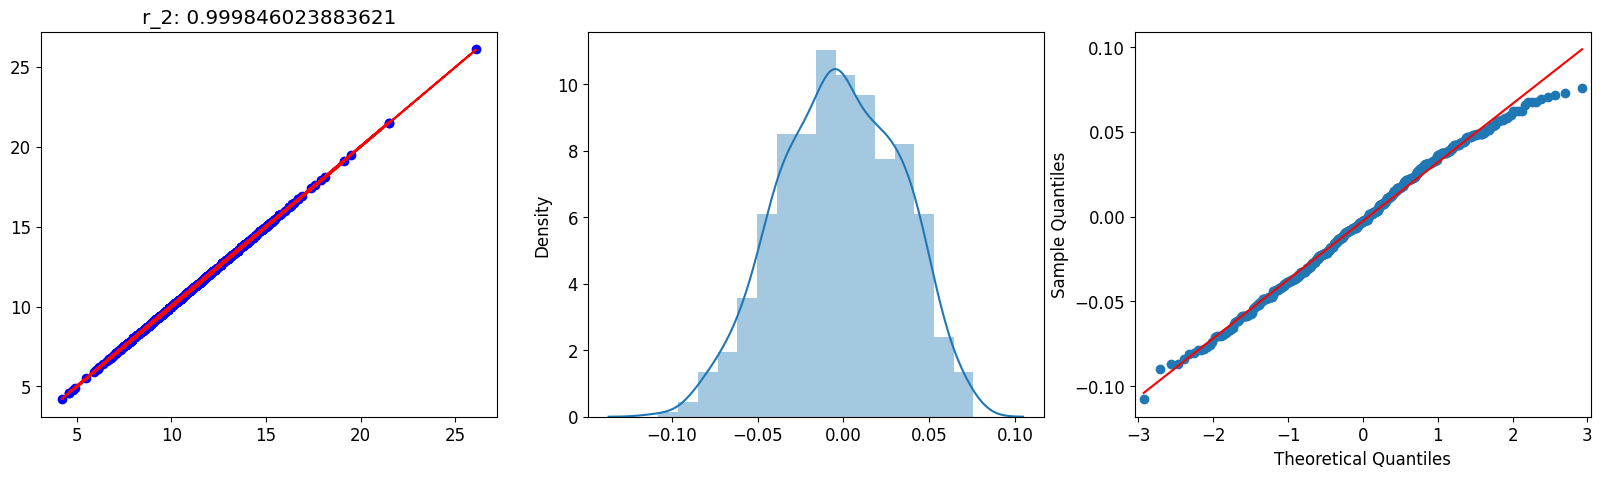

In [316]:
r_2_regresion_lineal(train,['Fuel Consumption City (L/100 km)','Hwy (L/100 km)'],['Comb (L/100 km)'])

r_2: 0.9997950715122937
Test de normalidad (kolmogorov-smirnov):
KstestResult(statistic=0.46717090607997136, pvalue=1.556743337479084e-78, statistic_location=0.08238343005043447, statistic_sign=1)


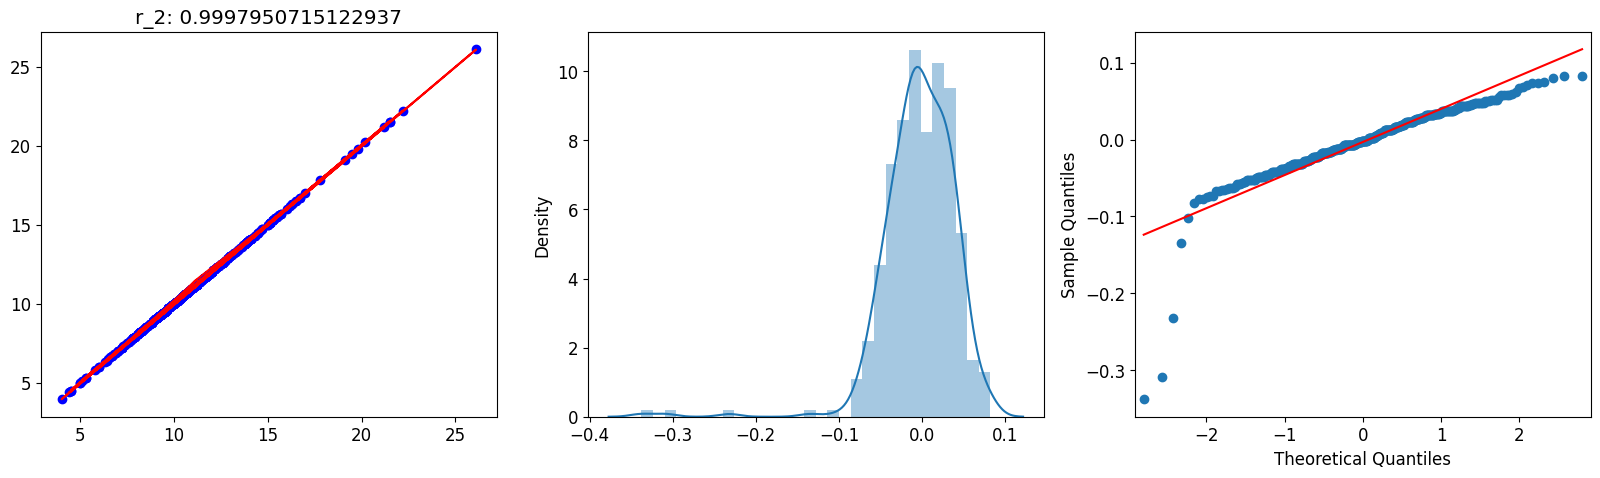

In [317]:
r_2_regresion_lineal(test_nolabel,['Fuel Consumption City (L/100 km)','Hwy (L/100 km)'],['Comb (L/100 km)'])

Podemos observar claramente quq el atributo Comb (L/100 km) está calculado a partir de Fuel Consumption City (L/100 km) y Hwy (L/100 km), por lo que podemos mantener Comb (L/100 km) y eliminar los otros dos. Sin embargo, vamos a mantenerlos todavia para comparar con el atributo CO2 Emissions(g/km).

#### CO2 EMISSIONS 

In [318]:
train.corr()

,Engine Size (L),Cylinders,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog
Engine Size (L),1.000000,0.916857,0.823824,0.722882,0.802054,0.808957,-0.385252
Cylinders,0.916857,1.000000,0.836961,0.716359,0.808126,0.819685,-0.452239
Fuel Consumption City (L/100 km),0.823824,0.836961,1.000000,0.917850,0.989132,0.962071,-0.485874
Hwy (L/100 km),0.722882,0.716359,0.917850,1.000000,0.966028,0.933776,-0.374793
Comb (L/100 km),0.802054,0.808126,0.989132,0.966028,1.000000,0.970278,-0.454922
CO2 Emissions (g/km),0.808957,0.819685,0.962071,0.933776,0.970278,1.000000,-0.481380
Smog,-0.385252,-0.452239,-0.485874,-0.374793,-0.454922,-0.481380,1.000000


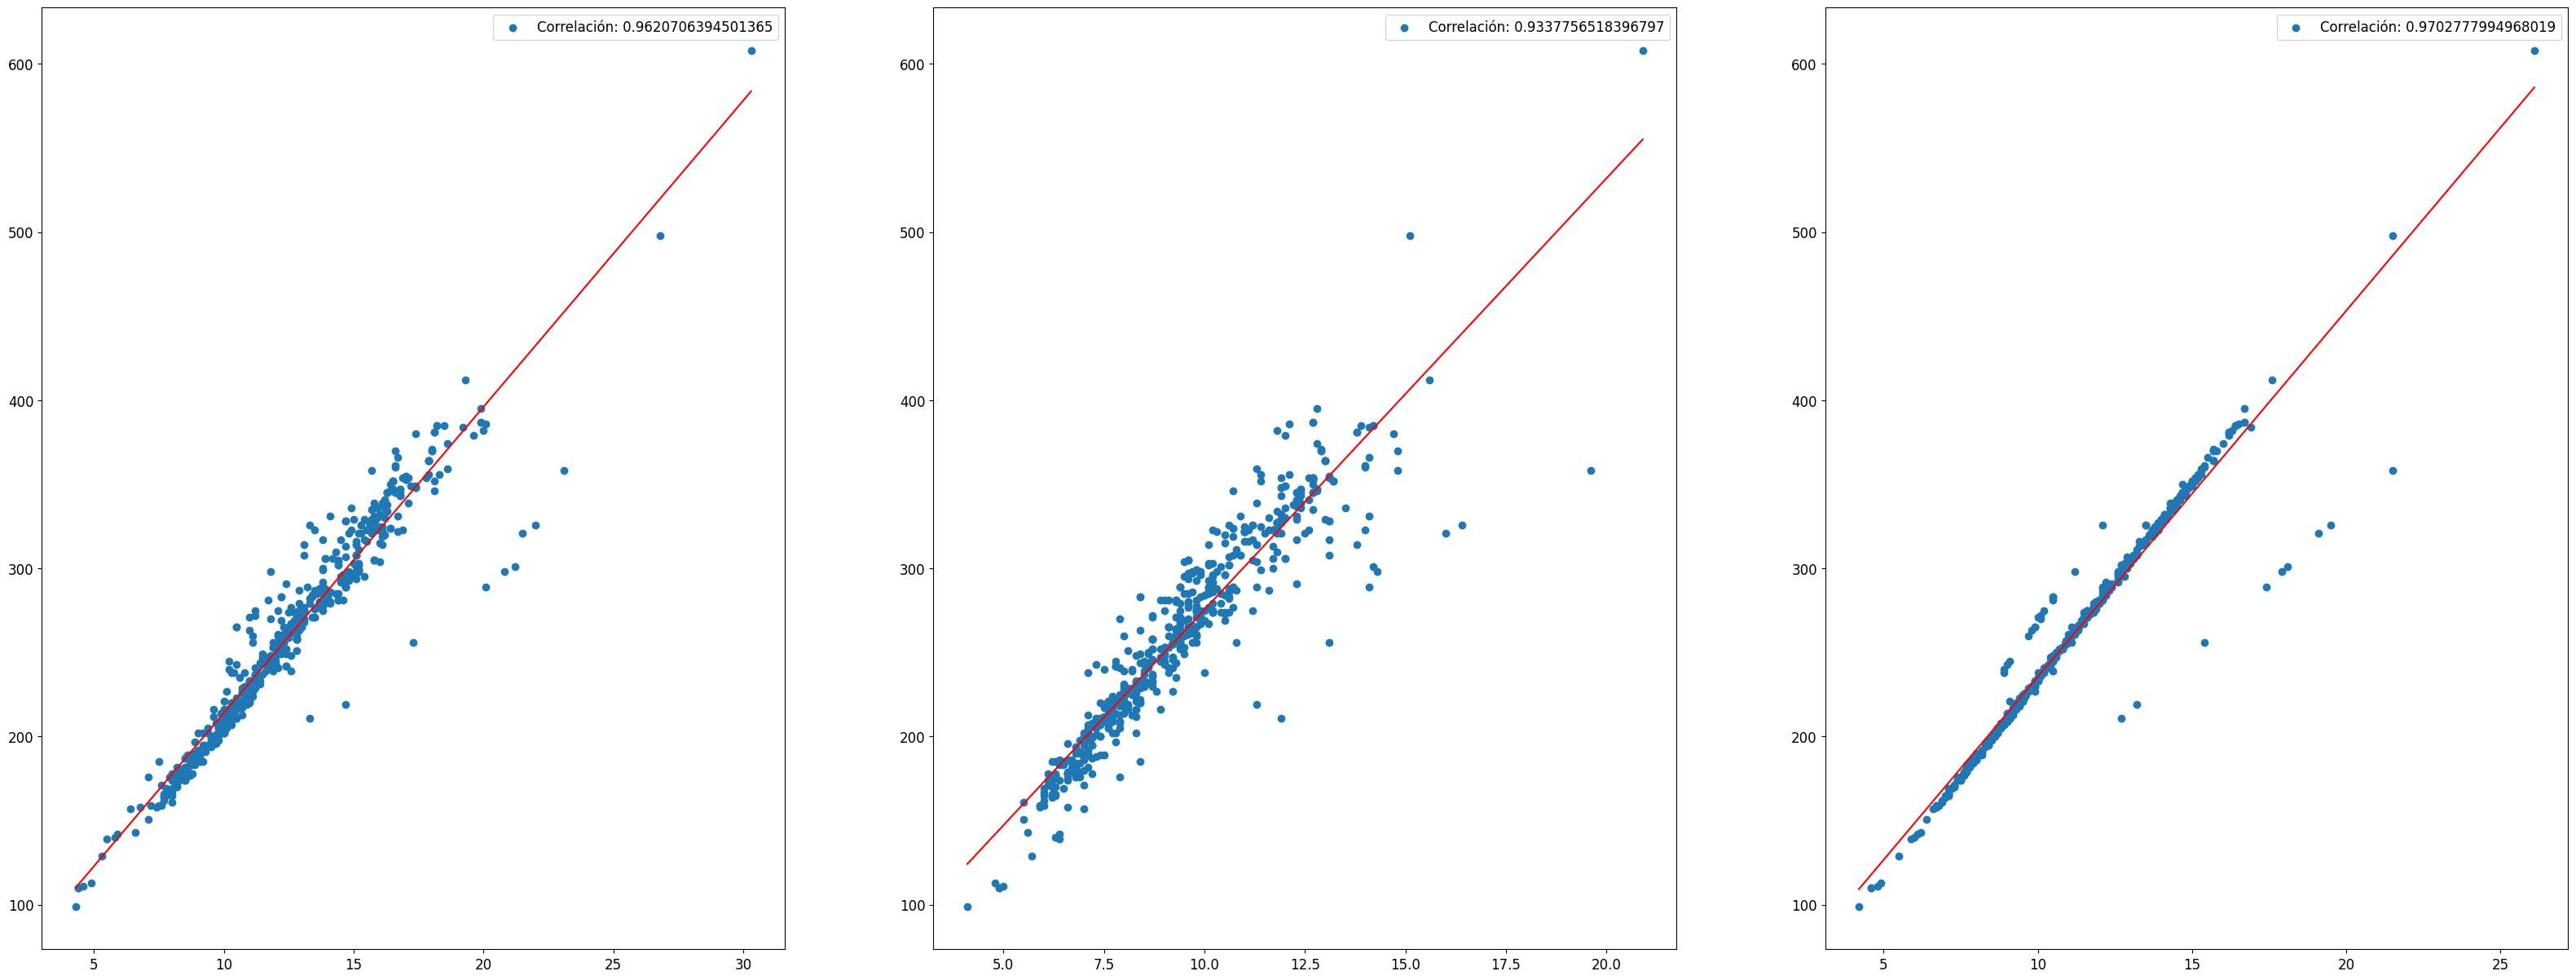

In [322]:
ax, fig = plt.subplots(1,3,figsize=(40,15))

corr_1 = train['Fuel Consumption City (L/100 km)'].corr(train['CO2 Emissions (g/km)'])
corr_2 = train['Hwy (L/100 km)'].corr(train['CO2 Emissions (g/km)'])
corr_3 = train['Comb (L/100 km)'].corr(train['CO2 Emissions (g/km)'])


fig[0].scatter(train['Fuel Consumption City (L/100 km)'],train['CO2 Emissions (g/km)'])
fig[0].plot(np.unique(train['Fuel Consumption City (L/100 km)']), np.poly1d(np.polyfit(train['Fuel Consumption City (L/100 km)'], train['CO2 Emissions (g/km)'], 1))(np.unique(train['Fuel Consumption City (L/100 km)'])),color='red')
fig[0].legend([f'Correlación: {corr_1}'])

fig[1].scatter(train['Hwy (L/100 km)'],train['CO2 Emissions (g/km)'])
fig[1].plot(np.unique(train['Hwy (L/100 km)']), np.poly1d(np.polyfit(train['Hwy (L/100 km)'], train['CO2 Emissions (g/km)'], 1))(np.unique(train['Hwy (L/100 km)'])),color='red')
fig[1].legend([f'Correlación: {corr_2}'])

fig[2].scatter(train['Comb (L/100 km)'],train['CO2 Emissions (g/km)'])
fig[2].plot(np.unique(train['Comb (L/100 km)']), np.poly1d(np.polyfit(train['Comb (L/100 km)'], train['CO2 Emissions (g/km)'], 1))(np.unique(train['Comb (L/100 km)'])),color='red')
fig[2].legend([f'Correlación: {corr_3}'])



Hay existencia de correlación lineal entre CO2 Emissions y los demás atributos, pero no hemos observado una clara combinación lineal entre ellos. Por tanto, vamos a mantener todos los atributos.

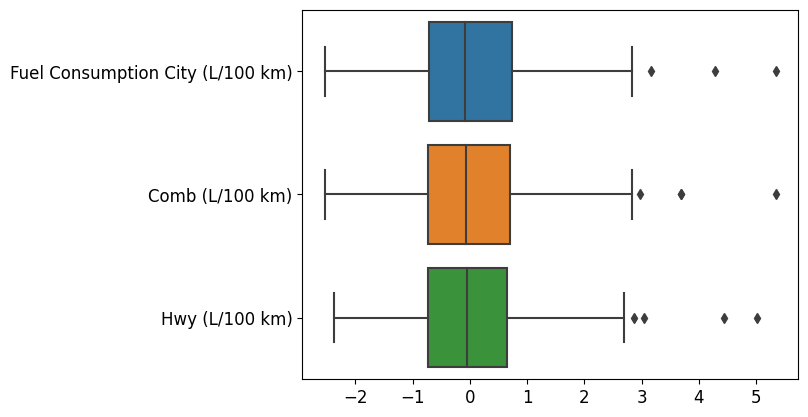

In [329]:
boxplot(train[['Fuel Consumption City (L/100 km)','Comb (L/100 km)','Hwy (L/100 km)']])

Vamos a identificar los outliers del atributo Comb (L/100 km) y vamos a sustituirlos por el valor calculado a partir de la regresión lineal.

In [330]:
index_comb = outliers(pd.DataFrame(train['Comb (L/100 km)'])).index
index_hwy = outliers(pd.DataFrame(train['Hwy (L/100 km)'])).index
index_city = outliers(pd.DataFrame(train['Fuel Consumption City (L/100 km)'])).index
print(index_comb)
print(index_hwy)
print(index_city)

Int64Index([195, 319, 332, 443], dtype='int64')
Int64Index([319, 332, 418, 443], dtype='int64')
Int64Index([195, 332, 443], dtype='int64')


,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog,Comb_calculado
195,2fdeb57c0d9,Lamborghini,Aventador Ultimae Roadster,Two-seater,6.5,12,AM7,Z,26.8,15.1,21.5,498,0,21.535
319,a98965d6869,GMC,Sierra 4WD FFV,Pickup truck: Standard,5.3,8,A6,E,22.0,16.4,19.5,326,1,19.480
332,55f27a7ed4a,GMC,Sierra 4WD Mud Terrain Tire FFV,Pickup truck: Standard,5.3,8,A6,E,23.1,19.6,21.5,358,1,21.525
443,5ba1e8ce15f,Bugatti,Chiron Pur Sport,Two-seater,8.0,16,AM7,Z,30.3,20.9,26.1,608,0,26.070


In [151]:
train_drop = train.drop(['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','id','Make','Model','Vehicle Class','Transmission','Fuel Type','Comb (mpg)'],axis=1)

In [62]:
r2 ,coeficientes = r_2_regresion_lineal(train,['Fuel Consumption City (L/100 km)','Hwy (L/100 km)'],['Comb (L/100 km)'])

Text(0.5, 1.0, 'Coeficiente de determinación: 0.999846023883621')

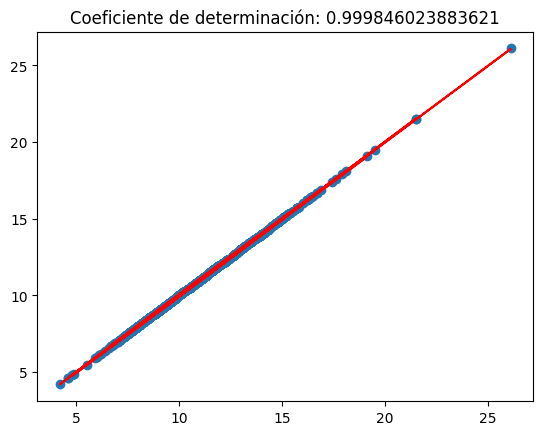

In [71]:
calculo = coeficientes[0][0]*train['Fuel Consumption City (L/100 km)']+coeficientes[0][1]*train['Hwy (L/100 km)']
plt.plot(train['Comb (L/100 km)'],calculo,color='red')
plt.scatter(train['Comb (L/100 km)'],train['Comb (L/100 km)'])
plt.title(f'Coeficiente de determinación: {r2}')

In [96]:
#quiero observar si el error de la regresion lineal es gaussiano es decir si se distribuye normal
error = train['Comb (L/100 km)'] - calculo



test = stats.kstest(error, 'norm')
test[1]



3.4152965448109427e-119

In [336]:
train

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog
0,ab44e9bec15,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,202,2
1,45926762371,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,181,4
2,e9be56e153f,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,274,2
3,077092760df,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,189,1
4,c1c2579b795,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,324,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,4a15a420076,BMW,M8 Gran Coupe Competition,Mid-size,4.4,8,AS8,Z,16.1,11.0,13.8,322,1
582,1ff291b6f89,Dodge,Charger (MDS),Full-size,5.7,8,A8,X,14.7,9.4,12.3,289,1
583,ff3fb82f77b,Ram,1500 4X4 EcoDiesel,Pickup truck: Standard,3.0,6,A8,D,11.1,8.0,9.7,260,0
584,cf742d4b653,Honda,Accord Sport/Touring,Full-size,2.0,4,AS10,X,10.4,7.4,9.1,211,4


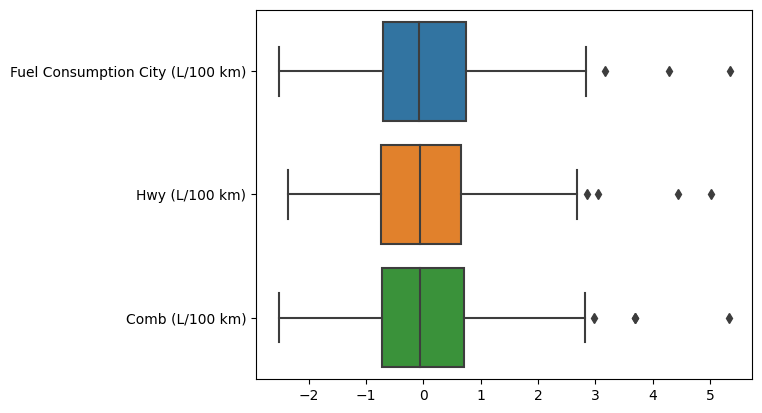

In [513]:
boxplot(train[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','Comb (L/100 km)']])

Text(0.5, 1.0, 'Hwy (L/100 km)')

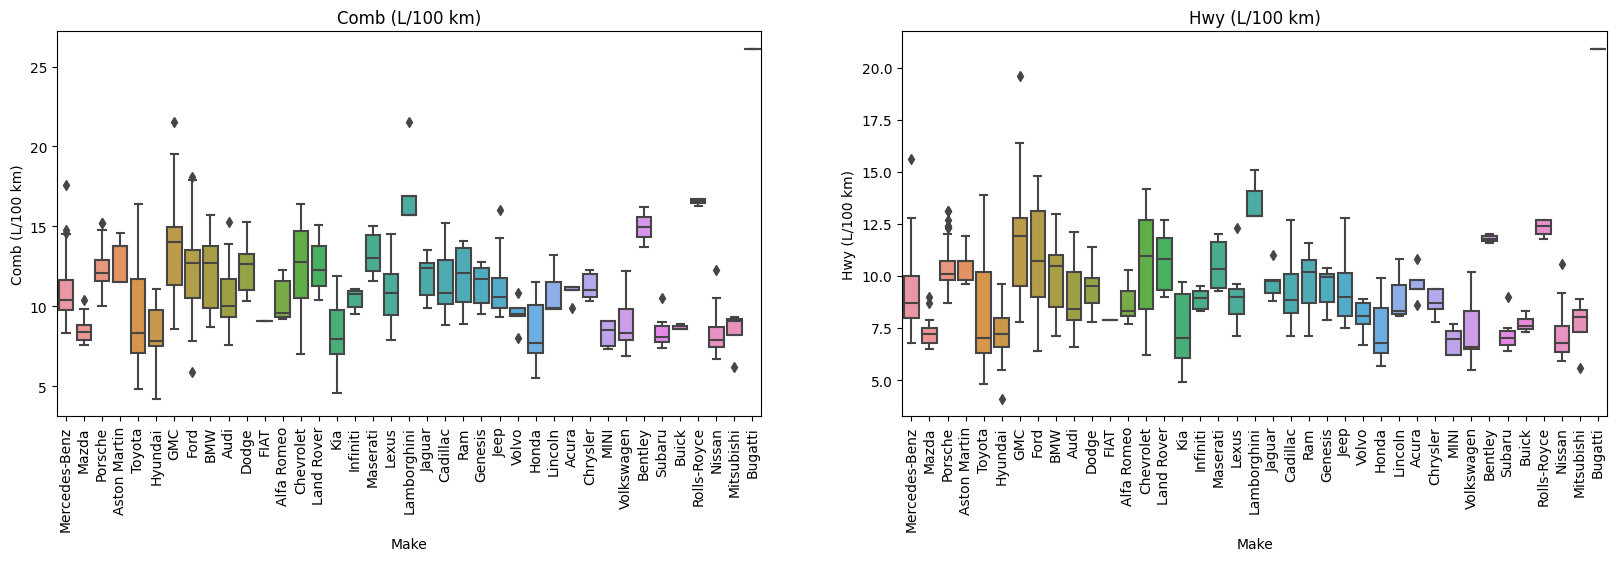

In [542]:
#vamos hacer boxplot seguún 'make'
ax, fig = plt.subplots(1,2,figsize=(20,5))
sns.boxplot(x='Make',y='Comb (L/100 km)',data=train,ax=fig[0])
fig[0].tick_params(axis='x', rotation=90)
fig[0].set_title('Comb (L/100 km)')

sns.boxplot(x='Make',y='Hwy (L/100 km)',data=train,ax=fig[1])
fig[1].tick_params(axis='x', rotation=90)
fig[1].set_title('Hwy (L/100 km)')


Gracias al boxplot encontramos los outliers de los tres atributos

In [539]:
outlier_consumo_train = outliers(train[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','Comb (L/100 km)']])
out = outlier_consumo_train['outliers']
outlier_consumo_train = train.loc[outlier_consumo_train.index]
outlier_consumo_train['outliers'] = out

outlier_consumo_test = outliers(test_nolabel[['Fuel Consumption City (L/100 km)','Hwy (L/100 km)','Comb (L/100 km)']])
out = outlier_consumo_test['outliers']
outlier_consumo_test = test_nolabel.loc[outlier_consumo_test.index]
outlier_consumo_test['outliers'] = out

In [540]:
outlier_consumo_train

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog,outliers
195,2fdeb57c0d9,Lamborghini,Aventador Ultimae Roadster,Two-seater,6.5,12,AM7,Z,26.8,15.1,21.5,498,0,"[Fuel Consumption City (L/100 km), Comb (L/100..."
319,a98965d6869,GMC,Sierra 4WD FFV,Pickup truck: Standard,5.3,8,A6,E,22.0,16.4,19.5,326,1,"[Hwy (L/100 km), Comb (L/100 km)]"
332,55f27a7ed4a,GMC,Sierra 4WD Mud Terrain Tire FFV,Pickup truck: Standard,5.3,8,A6,E,23.1,19.6,21.5,358,1,"[Fuel Consumption City (L/100 km), Hwy (L/100 ..."
418,ffc797bb6e6,GMC,Sierra FFV,Pickup truck: Standard,5.3,8,A6,E,21.5,16.0,19.1,321,1,[Hwy (L/100 km)]
443,5ba1e8ce15f,Bugatti,Chiron Pur Sport,Two-seater,8.0,16,AM7,Z,30.3,20.9,26.1,608,0,"[Fuel Consumption City (L/100 km), Hwy (L/100 ..."


In [533]:
outlier_consumo_test

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km)
35,11f073fbf9c,Hyundai,IONIQ Blue,Full-size,1.6,4,AM6,X,4.0,3.9,4.0,94
63,eb98a3e05d1,Bugatti,Chiron,Two-seater,8.0,16,AM7,Z,26.8,16.6,22.2,522
111,f231e384fcb,Bugatti,Chiron Super Sport,Two-seater,8.0,16,AM7,Z,30.3,20.9,26.1,608
133,72eab9a6fd9,Ram,1500 4X4 TRX,Pickup truck: Standard,6.2,8,A8,Z,22.4,16.5,19.8,465
215,44deb19dfc9,Chevrolet,Silverado FFV,Pickup truck: Standard,5.3,8,A6,E,21.5,16.0,19.1,321
263,a4b1bbfe887,Chevrolet,Silverado 4WD Mud Terrain Tire FFV,Pickup truck: Standard,5.3,8,A6,E,23.1,19.6,21.5,358
279,93289ba1d46,Chevrolet,Silverado 4WD FFV,Pickup truck: Standard,5.3,8,A6,E,22.0,16.4,19.5,326
298,eb474ad448f,Lamborghini,Aventador Countach,Two-seater,6.5,12,AM7,Z,26.5,14.6,21.2,489
302,008baf297b8,Mercedes-Benz,AMG G 63 4x4 Squared,SUV: Standard,4.0,8,A9,Z,21.5,18.7,20.2,470
331,cc52460cd6c,Ford,F-150 4X4 FFV (Without Stop-Start),Pickup truck: Standard,5.0,8,AS10,E,20.7,14.2,17.8,295


<Axes: xlabel='Make', ylabel='Smog'>

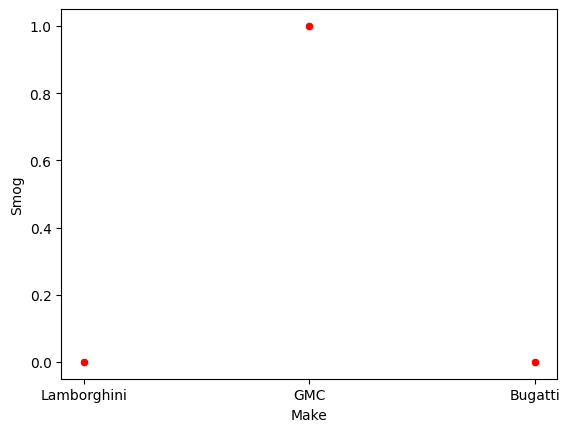

In [536]:
sns.scatterplot(x='Make',y='Smog',data=outlier_consumo_train,color='red')



In [537]:
#comprueba si hay filas en train q se repiten en test
train_sin_id
train['id'].isin(test_nolabel['id']).any()

False

In [509]:
train.corr()

,Engine Size (L),Cylinders,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog
Engine Size (L),1.000000,0.916857,0.823824,0.722882,0.802054,0.808957,-0.385252
Cylinders,0.916857,1.000000,0.836961,0.716359,0.808126,0.819685,-0.452239
Fuel Consumption City (L/100 km),0.823824,0.836961,1.000000,0.917850,0.989132,0.962071,-0.485874
Hwy (L/100 km),0.722882,0.716359,0.917850,1.000000,0.966028,0.933776,-0.374793
Comb (L/100 km),0.802054,0.808126,0.989132,0.966028,1.000000,0.970278,-0.454922
CO2 Emissions (g/km),0.808957,0.819685,0.962071,0.933776,0.970278,1.000000,-0.481380
Smog,-0.385252,-0.452239,-0.485874,-0.374793,-0.454922,-0.481380,1.000000


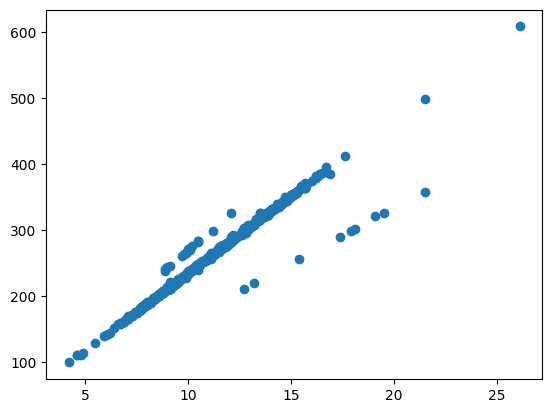

In [512]:
plt.scatter(train['Comb (L/100 km)'],train['CO2 Emissions (g/km)'])

In [494]:
boxplot(train[['']])

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),CO2 Emissions (g/km),Smog
0,ab44e9bec15,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,202,2
1,45926762371,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,181,4
2,e9be56e153f,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,274,2
3,077092760df,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,189,1
4,c1c2579b795,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,324,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,4a15a420076,BMW,M8 Gran Coupe Competition,Mid-size,4.4,8,AS8,Z,16.1,11.0,13.8,322,1
582,1ff291b6f89,Dodge,Charger (MDS),Full-size,5.7,8,A8,X,14.7,9.4,12.3,289,1
583,ff3fb82f77b,Ram,1500 4X4 EcoDiesel,Pickup truck: Standard,3.0,6,A8,D,11.1,8.0,9.7,260,0
584,cf742d4b653,Honda,Accord Sport/Touring,Full-size,2.0,4,AS10,X,10.4,7.4,9.1,211,4


In [ ]:
train

Podemos observar que las diferencias son mayores que 0,5 por lo consiguiente, se puede afirmar que el error -1 es debido a un redondeo. Ya que, si 
hubiera aparecido diferencia menor de 0,5

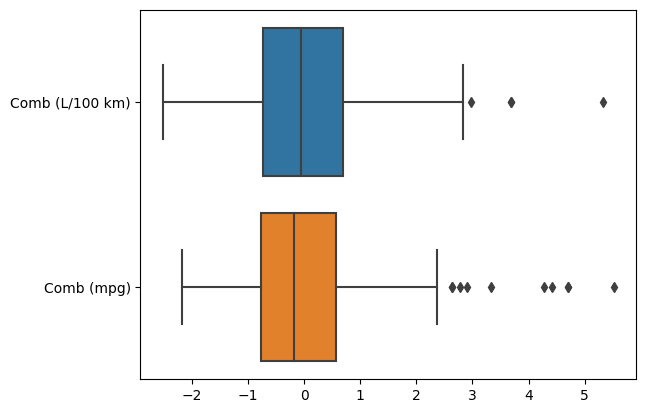

In [394]:
boxplot(train[['Comb (L/100 km)','Comb (mpg)']])

Encontramos en el boxplot la presencia de outliers en ambos atributos, tanto en Comb (L/100 km) como en Comb (mpg).

In [412]:
outliers_boxplot=outliers(train[['Comb (L/100 km)','Comb (mpg)']])
outliers_boxplot_km = outliers_boxplot[outliers_boxplot['outliers'].apply(lambda x: 'Comb (L/100 km)' in x)]
outliers_boxplot_mpg = outliers_boxplot[outliers_boxplot['outliers'].apply(lambda x: 'Comb (mpg)' in x)]

In [411]:
outliers_error

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog,error_redondeo_mpg
45,5d8d2afea71,BMW,X3 xDrive30i,SUV: Small,2.0,4,AS8,Z,11.0,8.5,9.9,29,230,4,-1.0
60,949bba6840d,Toyota,Corolla,Compact,2.0,4,AV10,X,7.6,5.9,6.8,42,159,4,-1.0
81,e8807aabca3,Lincoln,Corsair AWD,SUV: Small,2.3,4,AS8,X,11.2,8.3,9.9,29,232,2,-1.0
82,9d0256ba083,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232,4,-1.0
141,b270289ffdd,BMW,X4 xDrive30i,SUV: Small,2.0,4,AS8,Z,11.0,8.5,9.9,29,230,4,-1.0
210,ad0323a6670,Mercedes-Benz,E 450 4MATIC Cabriolet,Subcompact,3.0,6,A9,Z,11.2,8.4,9.9,29,233,3,-1.0
351,ac5e6fc1f93,Jaguar,F-PACE P250,SUV: Small,2.0,4,AS8,Z,10.7,8.8,9.9,29,227,4,-1.0
380,0de6c670637,Hyundai,Santa Fe AWD,SUV: Small,2.5,4,AM8,X,11.0,8.5,9.9,29,233,2,-1.0
420,36b35419813,GMC,Sierra 4WD,Pickup truck: Standard,3.0,6,A10,D,10.5,9.1,9.9,29,265,1,-1.0
424,ee87774154c,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,3,-1.0


In [414]:
outliers_boxplot_km

,Comb (L/100 km),Comb (mpg),outliers
195,21.5,13,[Comb (L/100 km)]
319,19.5,14,[Comb (L/100 km)]
332,21.5,13,[Comb (L/100 km)]
443,26.1,11,[Comb (L/100 km)]


Encontramos que la mayoría de los outliers pertenecen a Comb (mpg), lo que 

In [200]:
prueba = train.iloc[:,1:4]
assert (prueba.groupby(['Make','Model']).value_counts() == 1).all() != True
assert (prueba.groupby(['Make','Vehicle Class']).value_counts() == 1).all() != True
assert (prueba.groupby(['Model','Vehicle Class']).value_counts() == 1).all() != True

In [201]:
prueba = test_nolabel.iloc[:,1:4]
assert (prueba.groupby(['Make','Model']).value_counts() == 1).all() != True
assert (prueba.groupby(['Make','Vehicle Class']).value_counts() == 1).all() != True
assert (prueba.groupby(['Model','Vehicle Class']).value_counts() == 1).all() != True

In [221]:
prueba_2 = train.iloc[:,1:3]

In [223]:
prueba_2.groupby(['Make']).get_group('Porsche')

,Make,Model
2,Porsche,Panamera 4 ST
27,Porsche,911 Carrera S
41,Porsche,718 Cayman GT4
46,Porsche,718 Boxster S
61,Porsche,Panamera 4 Executive
67,Porsche,Panamera Turbo S Executive
75,Porsche,911 GT3 Touring
110,Porsche,718 Boxster GTS 4.0
123,Porsche,911 Carrera 4 GTS
129,Porsche,718 Boxster


In [224]:
def Modelos_columnas(df):
    df_1 = df.copy()
    df_1['Model']= df_1['Model'].apply(lambda x: x.split(' '))
    lista = []
    for i in df_1['Model']:
        for j in i:
            lista.append(j)
    lista = list(set(lista))
    #creo las columnas de la lista
    for i in lista:
        df_1[i] = 0
    #relleno las columnas
    for i in range(len(df_1)):
        for j in df_1['Model'][i]:
            df_1[j][i] = 1
    return df_1, len(lista)

In [226]:
train_1 = Modelos_columnas(train)[0]

C:\Users\andre\AppData\Local\Temp\ipykernel_8528\1902065531.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[i] = 0
C:\Users\andre\AppData\Local\Temp\ipykernel_8528\1902065531.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[i] = 0
C:\Users\andre\AppData\Local\Temp\ipykernel_8528\1902065531.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [227]:
train_1= train_1.drop(['Model','Make'],axis=1)

In [228]:
test_1 = Modelos_columnas(test_nolabel)[0]

C:\Users\andre\AppData\Local\Temp\ipykernel_8528\1902065531.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[i] = 0
C:\Users\andre\AppData\Local\Temp\ipykernel_8528\1902065531.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[i] = 0
C:\Users\andre\AppData\Local\Temp\ipykernel_8528\1902065531.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [229]:
test_1= test_1.drop(['Model','Make'],axis=1)

In [230]:
#añadir a test_1 las columnas que no estan en test_1 y si en train_1

for i in train_1.columns:
    if i not in test_1.columns:
        test_1[i] = 0

C:\Users\andre\AppData\Local\Temp\ipykernel_8528\2905549253.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_1[i] = 0
C:\Users\andre\AppData\Local\Temp\ipykernel_8528\2905549253.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_1[i] = 0
C:\Users\andre\AppData\Local\Temp\ipykernel_8528\2905549253.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

In [231]:
#vamos a hacer cross_val_predict con un modeo de arbol de decision
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict

y = train['Smog']
#dummies de Fuel Type y Transmission

train_1 = pd.get_dummies(train_1,columns=['Fuel Type','Transmission'],drop_first=True)
test_1 = pd.get_dummies(test_1,columns=['Fuel Type','Transmission'],drop_first=True)



In [233]:
train_1 = train_1.drop('id',axis=1)
test_1 = test_1.drop('id',axis=1)

In [236]:
train_1 = pd.get_dummies(train_1,columns=['Vehicle Class'],drop_first=True)
test_1 = pd.get_dummies(test_1,columns=['Vehicle Class'],drop_first=True)

In [255]:
#añade las columnas que no estan en train_1 y si en test_1
for i in test_1.columns:
    if i not in train_1.columns:
        train_1[i] = 0

In [288]:
y = train['Smog']
train_1 = train_1.drop('Smog',axis=1)
test_1 = test_1.drop('Smog',axis=1)

In [324]:
#bagging
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
#Naive Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split

bagging = BaggingRegressor(base_estimator=BernoulliNB(),n_estimators=100,random_state=0)
X_train, X_test, y_train, y_test = train_test_split(train_1, y, test_size=0.2, random_state=0)
bagging.fit(X_train,y_train)
predicciones = bagging.predict(X_test)
predicciones = np.round(predicciones)

c:\Users\andre\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [325]:
from sklearn.metrics import f1_score
f1_score(y_test,predicciones,average='macro')

0.43011048485595504

In [301]:
csv(predicciones,'bagging_2.csv',test_nolabel)

In [289]:
model = DecisionTreeRegressor(random_state=20)

#split de train_1



model.fit(X_train,y_train)


DecisionTreeRegressor(random_state=20)

In [290]:
#f1_score
from sklearn.metrics import f1_score
#f1_score recibe como parametros el y_test y las predicciones
predictions = model.predict(X_test)


In [292]:
predicciones_reales = model.predict(test_1)

In [283]:
predicciones_reales

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [291]:
f1_score(y_test,predictions,average='macro')

0.7599021590840748

In [204]:
df_1 =train.copy()
df_1['Model']= df_1['Model'].apply(lambda x: x.split(' '))
lista = []

In [208]:
for i in df_1['Model']:
        for j in i:
            lista.append(j)
lista = list(set(lista))

In [211]:
lista.remove('')

In [212]:
for i in lista:
    df_1[i] = 0

C:\Users\andre\AppData\Local\Temp\ipykernel_8528\1116393544.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[i] = 0
C:\Users\andre\AppData\Local\Temp\ipykernel_8528\1116393544.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_1[i] = 0
C:\Users\andre\AppData\Local\Temp\ipykernel_8528\1116393544.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

A
250
4MATIC
Hatch
Mazda3
5-Door
Panamera
4
ST
CX-3
4WD
DBS
V12
RAV4
AWD
LE
Elantra
Corolla
Yukon
4WD
(No
Stop-Start)
Transit
Connect
Wagon
LWB
FFV
M235i
xDrive
Gran
Coupe
SQ8
quattro
Sierra
4WD
Charger
AWD
Bronco
Black
Diamond
4WD
Ranger
4WD
Tremor
Mustang
Convertible
(High
Performance)
Yukon
XL
4WD
(No
Stop-Start)
500X
AWD
Giulia
Quadrifoglio
Camaro
ZL1
Transit
Connect
Wagon
LWB
FFV
Kona
Range
Rover
Velar
P340
Silverado
4WD
Mud
Terrain
Tire
Sorento
AWD
GLS
450
4MATIC
SUV
911
Carrera
S
QX50
AWD
New
Range
Rover
P400
LWB
Range
Rover
Sport
HST
P400
Camaro
Quattroporte
Trofeo
LC
500
Convertible
Huracan
evo
Spyder
Highlander
AWD
E-PACE
P250
Escalade
4WD
(No
Stop-Start)
Traverse
AWD
NX
350
AWD
F
SPORT
1500
4X4
eTorque
718
Cayman
GT4
GV70
AWD
Sierra
4WD
(No
Stop-Start)
430i
xDrive
Cabriolet
X3
xDrive30i
718
Boxster
S
Forte
5
Sierra
M8
Coupe
Competition
X3
M
Yukon
Grand
Wagoneer
4X4
Sierra
4WD
Mud
Terrain
Tire
M4
Competition
Coupe
M
xDrive
Niro
FE
M4
Competition
Cabriolet
M
xDrive
F-150
Tremo

TypeError: 'Axes' object is not subscriptable

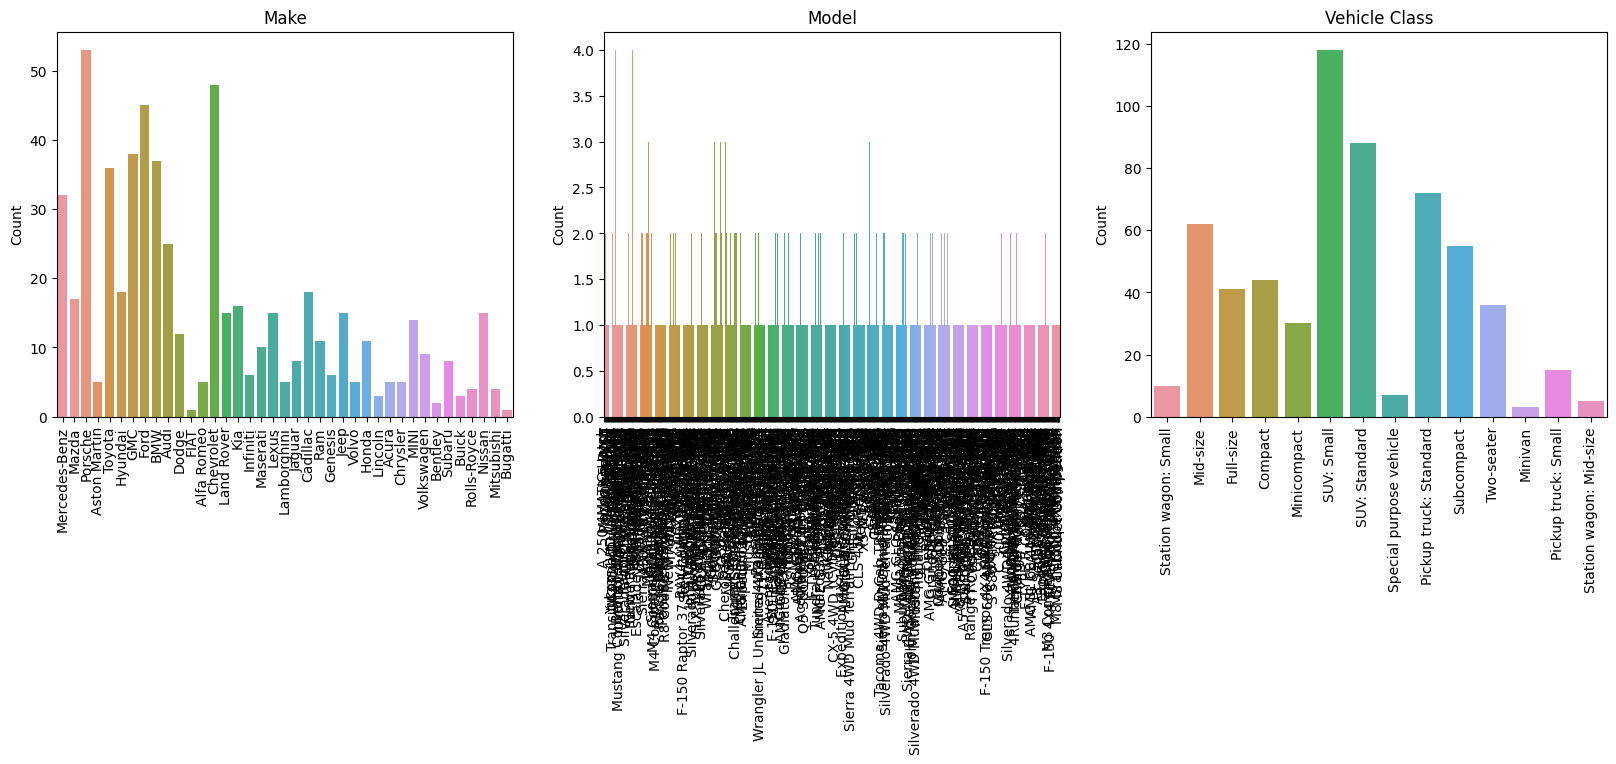

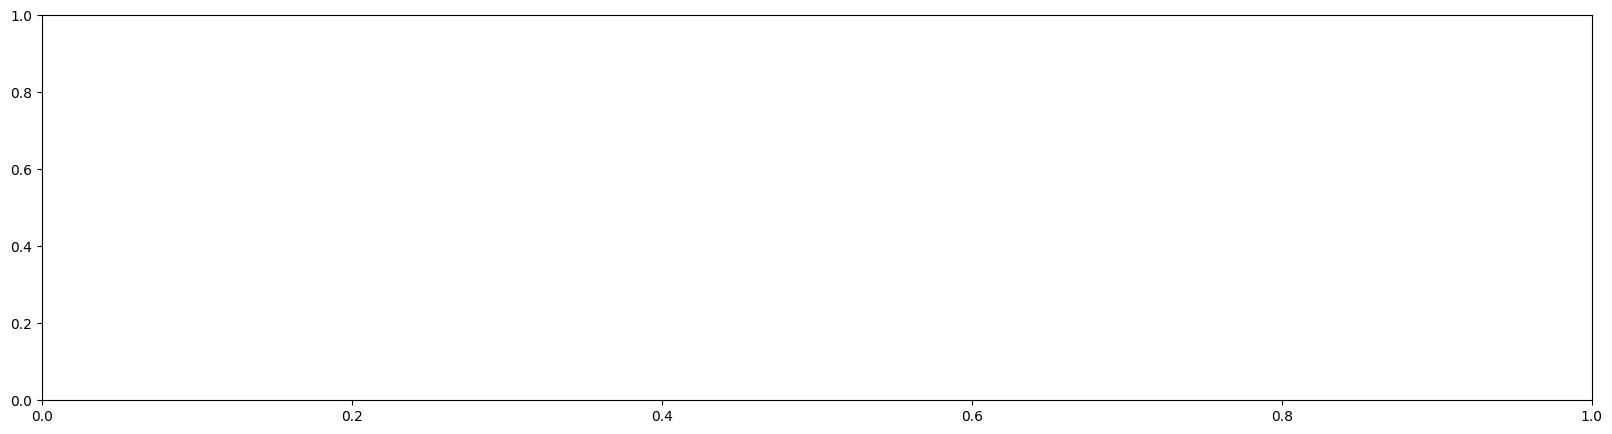

In [528]:
bar_plot(train,['Make','Model','Vehicle Class'])
#solo quiero presenatr el make
bar_plot(train,['Make'])

In [46]:
for i in train.columns:
    print(i,train[i].nunique())

id 586
Make 39
Model 488
Vehicle Class 14
Engine Size (L) 35
Cylinders 7
Transmission 23
Fuel Type 4
Fuel Consumption City (L/100 km) 135
Hwy (L/100 km) 96
Comb (L/100 km) 116
Comb (mpg) 41
CO2 Emissions (g/km) 211
Smog 5


In [47]:
for i in test_nolabel.columns:
    print(i,test_nolabel[i].nunique())

id 390
Make 37
Model 344
Vehicle Class 14
Engine Size (L) 34
Cylinders 7
Transmission 22
Fuel Type 4
Fuel Consumption City (L/100 km) 123
Hwy (L/100 km) 95
Comb (L/100 km) 114
Comb (mpg) 42
CO2 Emissions (g/km) 190


Podemos observar que en el dataset de entrenamiento encontramos diferentes números en cuanto a marcas y modelos de coches 
al dataset de test. Esto puede suponer un problema ya que si entrenamos nuestro modelo con modelos de coche que no se encuentren
en el dataset de test 

In [74]:
#vamos a estudiar con chi-cuadrado la realcion entre las variables categóricas y la variable objetivo
#para ello vamos a hacer una función que nos devuelva un dataframe con los valores de chi-cuadrado y p-value

def 

3      1
7      2
10     1
58     2
59     1
60     4
72     2
95     4
111    2
113    2
151    4
167    3
176    2
189    1
255    2
256    2
270    2
277    2
281    1
288    2
290    2
293    3
300    4
301    3
302    3
303    2
312    2
316    2
359    4
394    2
396    3
408    2
415    1
477    2
503    4
504    4
509    4
519    4
532    4
544    1
565    4
567    4
571    2
579    4
Name: Smog, dtype: int64

In [44]:
train_dummies = pd.get_dummies(train,columns=['Make','Model','Vehicle Class'],drop_first=True)

In [45]:
train_dummies.head()

,id,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),...,Vehicle Class_Minivan,Vehicle Class_Pickup truck: Small,Vehicle Class_Pickup truck: Standard,Vehicle Class_SUV: Small,Vehicle Class_SUV: Standard,Vehicle Class_Special purpose vehicle,Vehicle Class_Station wagon: Mid-size,Vehicle Class_Station wagon: Small,Vehicle Class_Subcompact,Vehicle Class_Two-seater
0,ab44e9bec15,2.0,4,AM7,Z,10.0,7.0,8.7,32,202,...,0,0,0,0,0,0,0,1,0,0
1,45926762371,2.0,4,AS6,X,8.6,6.7,7.7,37,181,...,0,0,0,0,0,0,0,0,0,0
2,e9be56e153f,2.9,6,AM8,Z,12.8,10.2,11.7,24,274,...,0,0,0,0,0,0,0,0,0,0
3,077092760df,2.0,4,AS6,X,8.6,7.4,8.1,35,189,...,0,0,0,0,0,0,0,0,0,0
4,c1c2579b795,5.2,12,A8,Z,16.4,10.7,13.8,20,324,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Se puede sar que uno de los dos atributos de

In [14]:
train.drop('Model Year',axis=1,inplace=True)
test_nolabel.drop('Model Year',axis=1,inplace=True)

In [9]:
test_nolabel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                390 non-null    object 
 1   Model Year                        390 non-null    int64  
 2   Make                              390 non-null    object 
 3   Model                             390 non-null    object 
 4   Vehicle Class                     390 non-null    object 
 5   Engine Size (L)                   390 non-null    float64
 6   Cylinders                         390 non-null    int64  
 7   Transmission                      390 non-null    object 
 8   Fuel Type                         390 non-null    object 
 9   Fuel Consumption City (L/100 km)  390 non-null    float64
 10  Hwy (L/100 km)                    390 non-null    float64
 11  Comb (L/100 km)                   390 non-null    float64
 12  Comb (mp

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(1, 0, 'Model Year'),
  Text(2, 0, 'Engine Size (L)'),
  Text(3, 0, 'Cylinders'),
  Text(4, 0, 'Fuel Consumption City (L/100 km)'),
  Text(5, 0, 'Hwy (L/100 km)'),
  Text(6, 0, 'Comb (L/100 km)'),
  Text(7, 0, 'Comb (mpg)'),
  Text(8, 0, 'CO2 Emissions (g/km)'),
  Text(9, 0, 'Smog')])

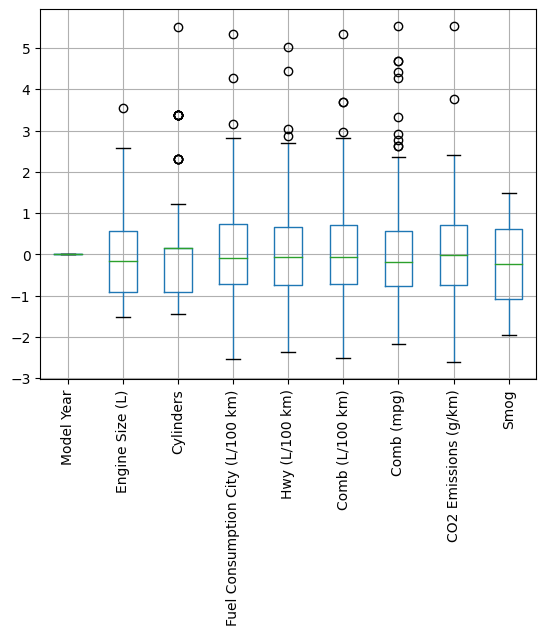

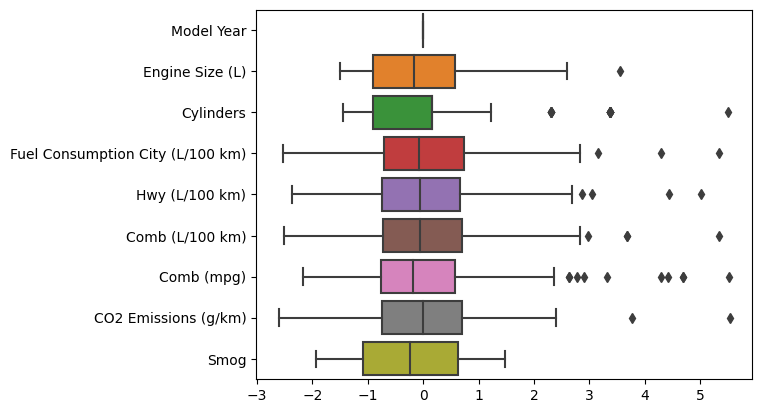

In [272]:
boxplot(train)#hola

In [274]:


# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))



# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            #square=True, linewidths=.5, cbar_kws={"shrink": .5})
    

corr


,Model Year,Engine Size (L),Cylinders,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
Model Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine Size (L),NaN,1.000000,0.916857,0.823824,0.722882,0.802054,-0.713731,0.808957,-0.385252
Cylinders,NaN,0.916857,1.000000,0.836961,0.716359,0.808126,-0.709976,0.819685,-0.452239
Fuel Consumption City (L/100 km),NaN,0.823824,0.836961,1.000000,0.917850,0.989132,-0.925557,0.962071,-0.485874
Hwy (L/100 km),NaN,0.722882,0.716359,0.917850,1.000000,0.966028,-0.888538,0.933776,-0.374793
Comb (L/100 km),NaN,0.802054,0.808126,0.989132,0.966028,1.000000,-0.930041,0.970278,-0.454922
Comb (mpg),NaN,-0.713731,-0.709976,-0.925557,-0.888538,-0.930041,1.000000,-0.926047,0.475578
CO2 Emissions (g/km),NaN,0.808957,0.819685,0.962071,0.933776,0.970278,-0.926047,1.000000,-0.481380
Smog,NaN,-0.385252,-0.452239,-0.485874,-0.374793,-0.454922,0.475578,-0.481380,1.000000


In [275]:
print (train[['Fuel Consumption City (L/100 km)', 'Hwy (L/100 km)']].corrwith(train['Comb (L/100 km)']))

Fuel Consumption City (L/100 km)    0.989132
Hwy (L/100 km)                      0.966028
dtype: float64


"'Figure' object is not subscriptable se debe a que no se puede acceder a un elemento de un objeto figure, entonces como se hace?\n"

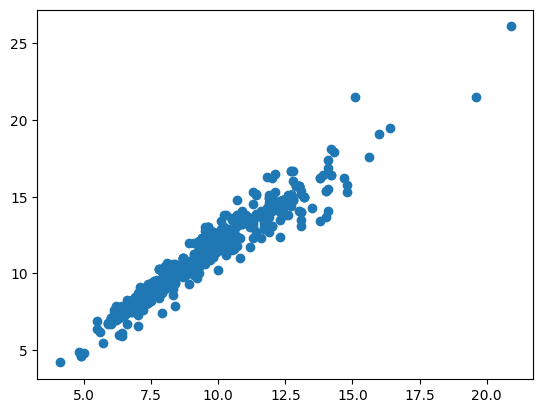

In [302]:
plt.scatter(train['Hwy (L/100 km)'],train['Comb (L/100 km)'])

def plot_scatter(df,columna):
    '''Devuelve un scatter plot de las columnas de df'''
    columnas = df.select_dtypes(exclude=['object']).columns
    for i in columnas:
        plt.scatter(df[i],df[columna])
        plt.xlabel(i)
        plt.ylabel(columna)
        plt.show()
        

''''Figure' object is not subscriptable se debe a que no se puede acceder a un elemento de un objeto figure, entonces como se hace?
'''

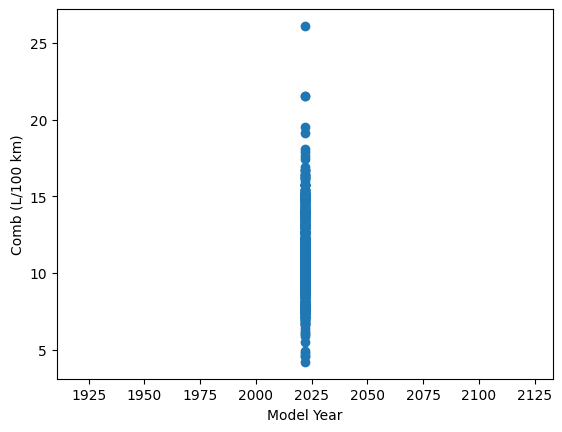

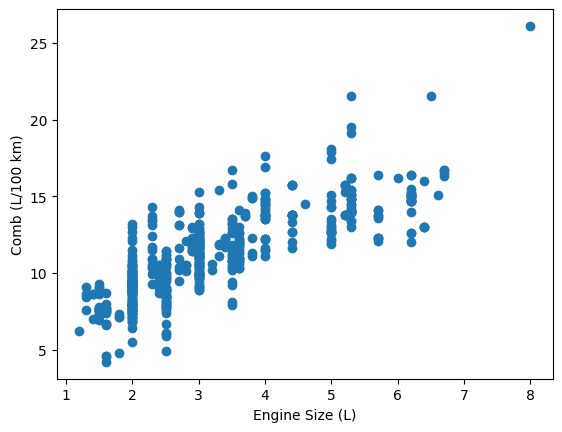

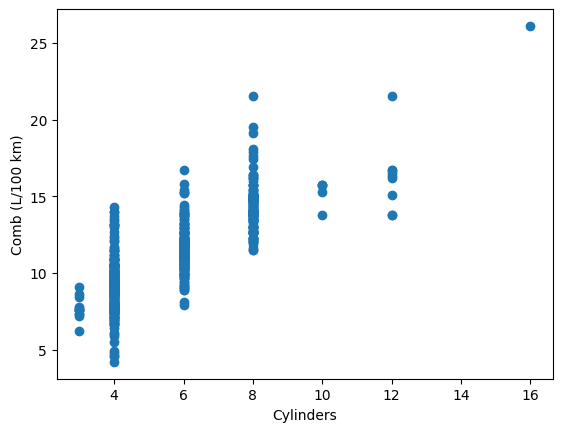

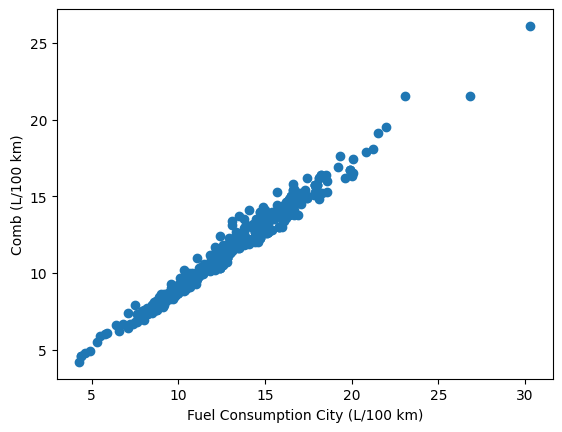

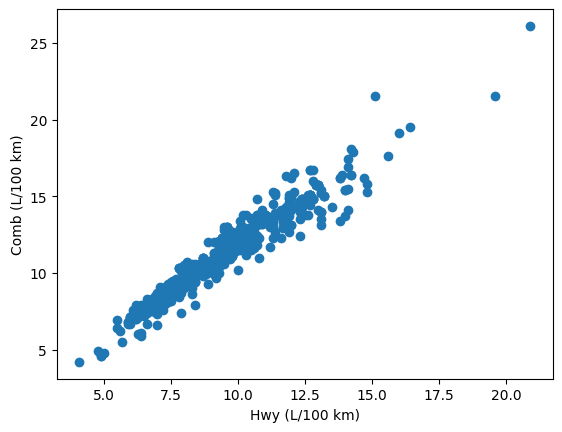

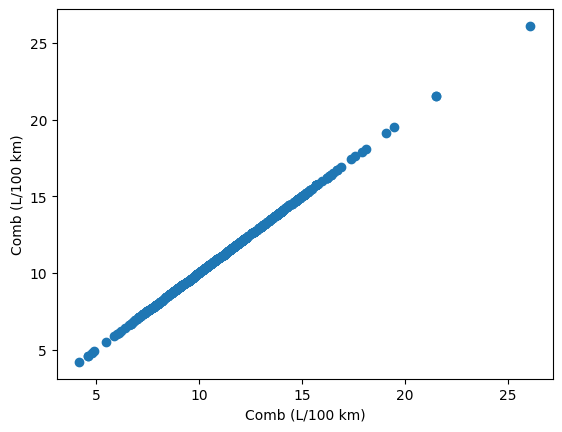

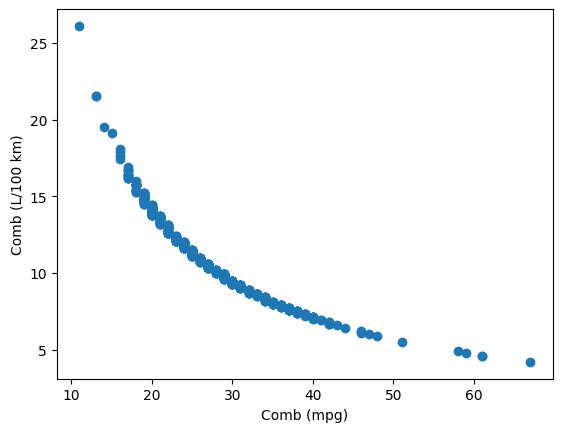

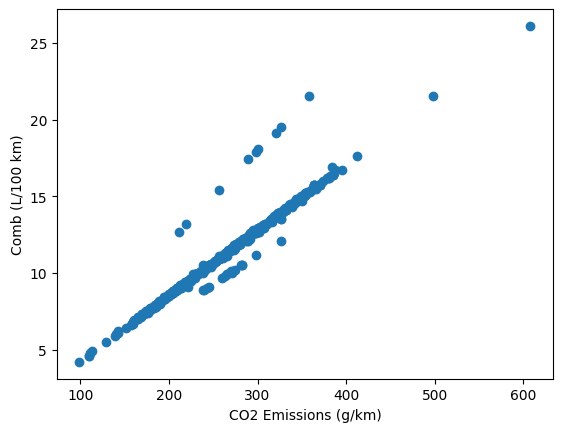

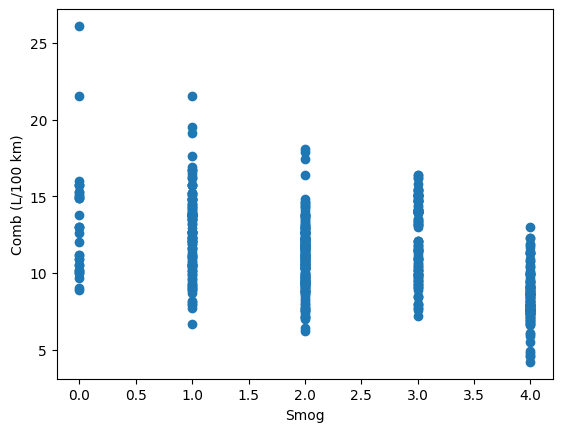

In [303]:
plot_scatter(train,'Comb (L/100 km)')

In [304]:
#Comb (mpg) y Comb (L/100 km) 
#mpg = 235.215/ L/100km
train

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),outliers
8,4d5f701cdde,2022,Audi,R8 Spyder Performance quattro,Two-seater,5.2,10,AM7,Z,17.9,12.1,15.3,18,356,[Cylinders]
9,76f30120e22,2022,GMC,Yukon XL 4WD (No Stop-Start),SUV: Standard,6.2,8,A10,Z,17.0,12.7,15.1,19,353,[Engine Size (L)]
11,dd33a84c757,2022,Chevrolet,Silverado 4WD,Pickup truck: Standard,6.2,8,A10,Z,15.7,11.9,14.0,20,329,[Engine Size (L)]
26,1796e50351e,2022,Chevrolet,Suburban 4WD (No Stop-Start),SUV: Standard,6.2,8,A10,Z,17.0,12.7,15.1,19,353,[Engine Size (L)]
35,11f073fbf9c,2022,Hyundai,IONIQ Blue,Full-size,1.6,4,AM6,X,4.0,3.9,4.0,71,94,"[Fuel Consumption City (L/100 km), Comb (mpg),..."
36,1ab4b8ae832,2022,Ford,Escape Hybrid,SUV: Small,2.5,4,AV,X,5.4,6.3,5.8,49,136,[Comb (mpg)]
43,cb4afc35d21,2022,Dodge,Challenger SRT Hellcat,Mid-size,6.2,8,A8,Z,17.6,10.7,14.5,19,339,[Engine Size (L)]
52,e0bd5de4641,2022,Mercedes-Benz,Maybach S 680 4MATIC Sedan,Full-size,6.0,12,A9,Z,19.4,11.2,15.7,18,369,[Cylinders]
63,eb98a3e05d1,2022,Bugatti,Chiron,Two-seater,8.0,16,AM7,Z,26.8,16.6,22.2,13,522,"[Engine Size (L), Cylinders, Fuel Consumption ..."
77,daa8a76141d,2022,Bentley,Bentayga Speed,SUV: Standard,6.0,12,AS8,Z,19.0,13.0,16.3,17,383,[Cylinders]


In [129]:
min,max = rango_outliers(train)

In [183]:

train_escaled[train_escaled > max ].dropna(axis=0,how='all')   
#quiero que no solo me salgan los outilers sino que me salga la fila entera
#quiero que me salga la fila entera y no solo los outliers



C:\Users\andre\AppData\Local\Temp\ipykernel_12060\2571518841.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  train_escaled[train_escaled > max ].dropna(axis=0,how='all')
C:\Users\andre\AppData\Local\Temp\ipykernel_12060\2571518841.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  indexes = train_escaled[train_escaled > max ].dropna(axis=0,how='all').index
C:\Users\andre\AppData\Local\Temp\ipykernel_12060\2571518841.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  prue

In [184]:
prueba

,id,Model Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog,outliers
4,c1c2579b795,0.0,Aston Martin,DBS V12,Minicompact,1.470777,3.367684,A8,Z,1.135162,0.535633,0.924065,-0.937241,0.988501,-1.086823,[Cylinders]
34,4ee8ba5a71b,0.0,Lamborghini,Huracan evo Spyder,Two-seater,1.470777,2.299504,AM7,Z,1.619587,1.501962,1.605742,-1.212058,1.740103,-1.941692,[Cylinders]
55,fbbcebc9b93,0.0,Kia,Niro FE,Station wagon: Small,-1.210712,-0.905037,AM6,X,-2.498019,-2.011961,-2.376684,4.696521,-2.433689,1.477787,[Comb (mpg)]
68,2900c2e6b2a,0.0,Audi,R8 Spyder Performance,Two-seater,1.470777,2.299504,AM7,Z,1.225992,0.359937,0.924065,-0.937241,0.956518,-1.941692,[Cylinders]
69,19419706fbd,0.0,Audi,R8 Coupe Performance quattro,Two-seater,1.470777,2.299504,AM7,Z,1.589310,1.150570,1.462231,-1.212058,1.500230,-1.941692,[Cylinders]
76,f60ce250af3,0.0,BMW,M760i xDrive Sedan,Full-size,2.513578,3.367684,AS8,Z,1.559034,1.062722,1.390476,-1.074650,1.468247,-1.086823,[Cylinders]
128,990ee624b73,0.0,Bentley,Continental GT Speed,Subcompact,2.066663,3.367684,AM8,Z,2.104011,1.106646,1.785130,-1.349467,1.868036,-1.086823,[Cylinders]
195,2fdeb57c0d9,0.0,Lamborghini,Aventador Ultimae Roadster,Two-seater,2.439092,3.367684,AM7,Z,4.283919,2.468291,3.686649,-1.899103,3.771029,-1.941692,"[Cylinders, Fuel Consumption City (L/100 km), ..."
197,e38433dd427,0.0,Aston Martin,DB11 V12,Minicompact,1.470777,3.367684,A8,Z,1.135162,0.535633,0.924065,-0.937241,0.988501,-1.086823,[Cylinders]
207,1318a48abac,0.0,Ford,Escape Hybrid AWD,SUV: Small,-0.540340,-0.905037,AV,X,-2.164977,-1.353100,-1.910274,2.910206,-1.969934,1.477787,[Comb (mpg)]


In [133]:
max['Smog']

3.1875264858593844

In [148]:
outliers(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                0 non-null      object 
 1   Model Year                        0 non-null      float64
 2   Make                              0 non-null      object 
 3   Model                             0 non-null      object 
 4   Vehicle Class                     0 non-null      object 
 5   Engine Size (L)                   0 non-null      float64
 6   Cylinders                         0 non-null      float64
 7   Transmission                      0 non-null      object 
 8   Fuel Type                         0 non-null      object 
 9   Fuel Consumption City (L/100 km)  0 non-null      float64
 10  Hwy (L/100 km)                    0 non-null      float64
 11  Comb (L/100 km)                   0 non-null      float64
 12  Comb (mp

C:\Users\andre\AppData\Local\Temp\ipykernel_12060\2646902563.py:30: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_outliers = df_outliers[df_outliers < min ]


Vemos que no hay un valor NaN en todo el dataset, por lo que no es necesario rellenar ningún dato.

Ahora, visualicemos con histogramas todos los datos que sean numéricos:

### 2. Estudio de las distintas variables

In [9]:
train.columns

Index(['id', 'Model Year', 'Make', 'Model', 'Vehicle Class', 'Engine Size (L)',
       'Cylinders', 'Transmission', 'Fuel Type',
       'Fuel Consumption City (L/100 km)', 'Hwy (L/100 km)', 'Comb (L/100 km)',
       'Comb (mpg)', 'CO2 Emissions (g/km)', 'Smog'],
      dtype='object')

Nuestras variables son:
- Model Year: año del modelo
- Make: marca del coche
- Model: modelo del coche
- Vehicle Class: clase del vehículo
- Engine Size: tamaño del motor
- Cylinders: número de cilindros
- Transmission: tipo de transmisión
- Fuel Type: tipo de combustible
- Fuel Consumption City (L/100 km): consumo de combustible en ciudad
- Hwy (L/100 km): consumo de combustible en carretera
- Comb (L/100 km): consumo de combustible combinado
- Fuel Consumption Comb (mpg): consumo de combustible combinado (millas por galón)
- CO2 Emissions(g/km): emisiones de CO2

Vamos a estudiar cada una de las variables para ver si podemos sacar alguna conclusión sobre ellas.


#### Model Year: año del modelo

In [10]:
train['Model Year'].head()

0    2022
1    2022
2    2022
3    2022
4    2022
Name: Model Year, dtype: int64

In [11]:
train['Model Year'].unique()


array([2022], dtype=int64)

In [12]:
train = train.drop(['Model Year'],axis=1)

Observamos que la variable Model Year tiene como valor único el año 2020, por lo que no nos aporta información. Por tanto, la eliminamos.

#### Make, Model, Vehicle Class: marca, modelo y clase del vehículo

Vamos a ver si podemos sacar alguna conclusión sobre estas variables. Para ello, vamos a observar si con alguna de las dos variables podemos saber
la otra variable. Por ejemplo, si con la marca y el modelo podemos saber la clase del vehículo, no sería necesario tener las tres variables.

In [13]:
estudio=train.iloc[:,1:4]
estudio.head()

,Make,Model,Vehicle Class
0,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small
1,Mazda,Mazda3 5-Door,Mid-size
2,Porsche,Panamera 4 ST,Full-size
3,Mazda,CX-3 4WD,Compact
4,Aston Martin,DBS V12,Minicompact


In [14]:
assert (estudio[['Model','Vehicle Class']].value_counts()!=1).any()
assert (estudio[['Make','Vehicle Class']].value_counts()!=1).any()
assert (estudio[['Make','Model']].value_counts()!=1).any()

In [15]:
(train.groupby(['Make','Model']).count()==1).any()
#encuentra la fila que hace que lo dearriba no sea tru
#encuntra si hay dupplicados en make y model
train[train.duplicated(subset=['Engine Size (L)','Cylinders'],keep=False)].sort_values(by=['Make','Model'])

dumies = pd.get_dummies(train,columns=['Make','Model','Vehicle Class','Transmission'],drop_first=True)

In [16]:
corr = train.iloc[4:,:].corr(method='pearson')

corr.style.background_gradient(cmap='coolwarm', axis=None)





,Engine Size (L),Cylinders,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
Engine Size (L),1.000000,0.916637,0.823131,0.721784,0.801275,-0.712760,0.808221,-0.387098
Cylinders,0.916637,1.000000,0.836298,0.715005,0.807255,-0.708713,0.818873,-0.454243
Fuel Consumption City (L/100 km),0.823131,0.836298,1.000000,0.917553,0.989096,-0.925216,0.961866,-0.488333
Hwy (L/100 km),0.721784,0.715005,0.917553,1.000000,0.965899,-0.888011,0.933429,-0.375993
Comb (L/100 km),0.801275,0.807255,0.989096,0.965899,1.000000,-0.929672,0.970086,-0.456908
Comb (mpg),-0.712760,-0.708713,-0.925216,-0.888011,-0.929672,1.000000,-0.925642,0.477262
CO2 Emissions (g/km),0.808221,0.818873,0.961866,0.933429,0.970086,-0.925642,1.000000,-0.483682
Smog,-0.387098,-0.454243,-0.488333,-0.375993,-0.456908,0.477262,-0.483682,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                586 non-null    object 
 1   Make                              586 non-null    object 
 2   Model                             586 non-null    object 
 3   Vehicle Class                     586 non-null    object 
 4   Engine Size (L)                   586 non-null    float64
 5   Cylinders                         586 non-null    int64  
 6   Transmission                      586 non-null    object 
 7   Fuel Type                         586 non-null    object 
 8   Fuel Consumption City (L/100 km)  586 non-null    float64
 9   Hwy (L/100 km)                    586 non-null    float64
 10  Comb (L/100 km)                   586 non-null    float64
 11  Comb (mpg)                        586 non-null    int64  
 12  CO2 Emis

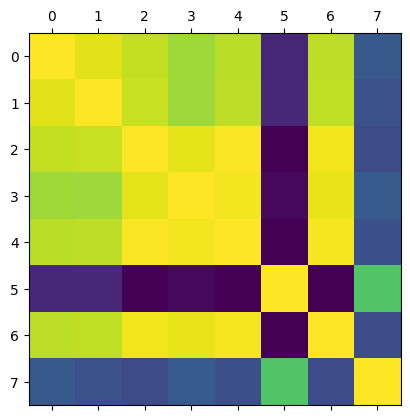

In [17]:
plt.matshow(corr)
train.info()

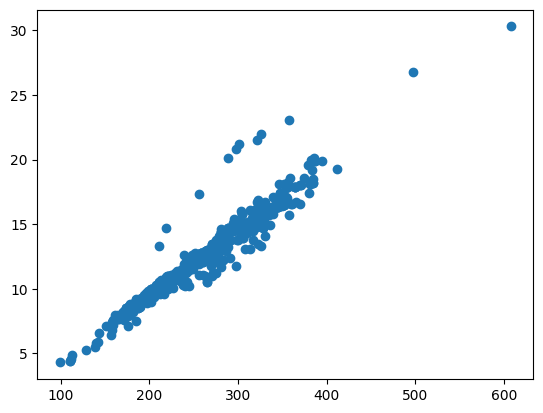

In [18]:
#plt.plot(train['CO2 Emissions (g/km)'],train['Comb (mpg)'])
#ahora representame su linea de regresion

plt.scatter(train['CO2 Emissions (g/km)'],train['Fuel Consumption City (L/100 km)'])

#quiero el plot de todas las columnas con todas las columnas
#como son 8 columnas, 8x8 = 64 plots


In [19]:
#una correlacion alta entre variables puede afectar a la prediccion ya que puede haber una relacion lineal entre ellas y al haber
#una relacion lineal entre ellas puede afectar a la prediccion, debido a que si hay una relacion lineal entre ellas, una de ellas
#un valor alto seria de 0,

Con los asserts podemos ver que no es posible saber la clase del vehículo con la marca y el modelo, por lo que las tres variables son necesarias 
(por ahora).

#### Engine Size, Cylinders y Transmission

Hemos agrupado estas tres variables porque creemos que pueden estar relacionadas. Por ejemplo, si el número de cilindros es 4, el tamaño del motor

In [20]:
estudio_1 = train.iloc[:,4:7]
estudio_1.head()

,Engine Size (L),Cylinders,Transmission
0,2.0,4,AM7
1,2.0,4,AS6
2,2.9,6,AM8
3,2.0,4,AS6
4,5.2,12,A8


In [21]:
estudio_1['Engine Size (L)'].unique()
estudio_1['Cylinders'].unique()
estudio_1['Transmission'].unique()

array(['AM7', 'AS6', 'AM8', 'A8', 'AS8', 'M6', 'A10', 'AS10', 'A9', 'M7',
       'AV8', 'AS9', 'AV', 'AM6', 'AS7', 'AV10', 'AV7', 'A6', 'AM9', 'M5',
       'AV6', 'AS5', 'AV1'], dtype=object)

In [22]:
assert (estudio_1[['Engine Size (L)','Cylinders']].value_counts()!=1).any()
assert (estudio_1[['Engine Size (L)','Transmission']].value_counts()!=1).any()
assert (estudio_1[['Cylinders','Transmission']].value_counts()!=1).any()

In [23]:
# quiero unir estudio y estudio_1
estudio_2 = pd.concat([estudio,estudio_1],axis=1)
estudio_2.head()

,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission
0,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7
1,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6
2,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8
3,Mazda,CX-3 4WD,Compact,2.0,4,AS6
4,Aston Martin,DBS V12,Minicompact,5.2,12,A8


In [24]:
#quiero comprobar si hay variables que pueden ser redundantes, es decir, por ejemplo con el mel y make saber engine size

assert (estudio_2[['Transmission','Vehicle Class','Make','Engine Size (L)','Cylinders']].value_counts()!=1).any()

In [25]:
estudio_2[['Model','Vehicle Class','Make','Engine Size (L)','Transmission']].value_counts()


Model                            Vehicle Class            Make       Engine Size (L)  Transmission
Sierra FFV                       Pickup truck: Standard   GMC        5.3              A6              2
Sierra 4WD FFV                   Pickup truck: Standard   GMC        5.3              A6              2
Transit Connect Wagon LWB FFV    Special purpose vehicle  Ford       2.0              AS8             2
F-150 4X4 FFV                    Pickup truck: Standard   Ford       3.3              AS10            2
Sierra 4WD Mud Terrain Tire FFV  Pickup truck: Standard   GMC        5.3              A6              2
                                                                                                     ..
Corsair AWD                      SUV: Small               Lincoln    2.0              AS8             1
                                                                     2.3              AS8             1
Corvette                         Two-seater               Chevrolet  

In [26]:
estudio['Make'].unique()

array(['Mercedes-Benz', 'Mazda', 'Porsche', 'Aston Martin', 'Toyota',
       'Hyundai', 'GMC', 'Ford', 'BMW', 'Audi', 'Dodge', 'FIAT',
       'Alfa Romeo', 'Chevrolet', 'Land Rover', 'Kia', 'Infiniti',
       'Maserati', 'Lexus', 'Lamborghini', 'Jaguar', 'Cadillac', 'Ram',
       'Genesis', 'Jeep', 'Volvo', 'Honda', 'Lincoln', 'Acura',
       'Chrysler', 'MINI', 'Volkswagen', 'Bentley', 'Subaru', 'Buick',
       'Rolls-Royce', 'Nissan', 'Mitsubishi', 'Bugatti'], dtype=object)

In [27]:
estudio['Vehicle Class'].unique()

array(['Station wagon: Small', 'Mid-size', 'Full-size', 'Compact',
       'Minicompact', 'SUV: Small', 'SUV: Standard',
       'Special purpose vehicle', 'Pickup truck: Standard', 'Subcompact',
       'Two-seater', 'Minivan', 'Pickup truck: Small',
       'Station wagon: Mid-size'], dtype=object)

In [28]:
#quiero estudiar si el modelo y vehicle class se repite en el dataset
estudio[['Model','Vehicle Class']].value_counts()# esto

Model                                Vehicle Class         
Sierra 4WD                           Pickup truck: Standard    4
Camaro                               Subcompact                4
Silverado 4WD Mud Terrain Tire       Pickup truck: Standard    4
Sierra                               Pickup truck: Standard    3
Corolla                              Compact                   3
                                                              ..
Explorer Timberline AWD              SUV: Standard             1
Expedition Timberline 4X4            SUV: Standard             1
Expedition 4X4 (Without Stop-Start)  SUV: Standard             1
Escape Hybrid AWD                    SUV: Small                1
Yukon XL 4WD (No Stop-Start)         SUV: Standard             1
Length: 488, dtype: int64

In [29]:
estudio[estudio['Model']=='Sierra 4WD']

,Make,Model,Vehicle Class
12,GMC,Sierra 4WD,Pickup truck: Standard
85,GMC,Sierra 4WD,Pickup truck: Standard
271,GMC,Sierra 4WD,Pickup truck: Standard
420,GMC,Sierra 4WD,Pickup truck: Standard


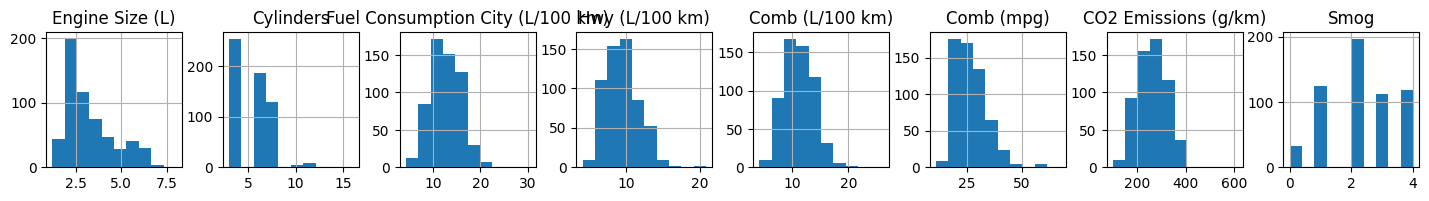

In [30]:
nearest_square = lambda number: np.power(np.round(np.sqrt(number)), 2)

int_columns = train.select_dtypes(include=(int, float))
sq = int(nearest_square(len(int_columns.columns)))

int_columns.hist(figsize=(20, 20), layout=(sq, sq))

clear_output()

Si nos fijamos en el historial de 'Model Year', vemos que todas las entradas al dataset tienen el mismo dato en esa columna.

Por tanto, concluimos que el año del modelo es irrelevante para la predicción del SMOG. En otras palabras, la ganancia de información de SMOG por MODEL YEAR es 0.

In [31]:
test_nolabel.columns

Index(['id', 'Model Year', 'Make', 'Model', 'Vehicle Class', 'Engine Size (L)',
       'Cylinders', 'Transmission', 'Fuel Type',
       'Fuel Consumption City (L/100 km)', 'Hwy (L/100 km)', 'Comb (L/100 km)',
       'Comb (mpg)', 'CO2 Emissions (g/km)'],
      dtype='object')

In [32]:
#quiero una tbala con los nombres de las columnas y los valores unicos de cada una
columns = train.columns
#Rango de valores de cada columna, excepto para las columnas con strings que pondremos unique e id no entra
ranges = {column: train[column].unique() if train[column].dtype == 'O' else [train[column].min(), train[column].max()] for column in columns if column != 'id'}

In [33]:
ranges

{'Make': array(['Mercedes-Benz', 'Mazda', 'Porsche', 'Aston Martin', 'Toyota',
        'Hyundai', 'GMC', 'Ford', 'BMW', 'Audi', 'Dodge', 'FIAT',
        'Alfa Romeo', 'Chevrolet', 'Land Rover', 'Kia', 'Infiniti',
        'Maserati', 'Lexus', 'Lamborghini', 'Jaguar', 'Cadillac', 'Ram',
        'Genesis', 'Jeep', 'Volvo', 'Honda', 'Lincoln', 'Acura',
        'Chrysler', 'MINI', 'Volkswagen', 'Bentley', 'Subaru', 'Buick',
        'Rolls-Royce', 'Nissan', 'Mitsubishi', 'Bugatti'], dtype=object),
 'Model': array(['A 250 4MATIC Hatch', 'Mazda3 5-Door', 'Panamera 4 ST', 'CX-3 4WD',
        'DBS V12', 'RAV4 AWD LE', 'Elantra', 'Corolla',
        'Yukon 4WD (No Stop-Start)', 'Transit Connect Wagon LWB FFV',
        'M235i xDrive Gran Coupe', 'SQ8 quattro', 'Sierra 4WD',
        'Charger AWD', 'Bronco Black Diamond 4WD', 'Ranger 4WD Tremor',
        'Mustang Convertible (High Performance)',
        'Yukon XL 4WD (No Stop-Start)', '500X AWD', 'Giulia Quadrifoglio',
        'Camaro ZL1', 'Kona', '

| Variables | Rango de valores | Definición |
| --- | --- | --- |
| {} | 1-10000 | Identificador de la muestra |
| ```
columns[1]``` | 2014 | Año del modelo |
quiero añadir [columns[1]] en la tabla de arriba para que se vea el nombre de la columna para ello 

In [34]:
train

,id,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Smog
0,ab44e9bec15,Mercedes-Benz,A 250 4MATIC Hatch,Station wagon: Small,2.0,4,AM7,Z,10.0,7.0,8.7,32,202,2
1,45926762371,Mazda,Mazda3 5-Door,Mid-size,2.0,4,AS6,X,8.6,6.7,7.7,37,181,4
2,e9be56e153f,Porsche,Panamera 4 ST,Full-size,2.9,6,AM8,Z,12.8,10.2,11.7,24,274,2
3,077092760df,Mazda,CX-3 4WD,Compact,2.0,4,AS6,X,8.6,7.4,8.1,35,189,1
4,c1c2579b795,Aston Martin,DBS V12,Minicompact,5.2,12,A8,Z,16.4,10.7,13.8,20,324,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,4a15a420076,BMW,M8 Gran Coupe Competition,Mid-size,4.4,8,AS8,Z,16.1,11.0,13.8,20,322,1
582,1ff291b6f89,Dodge,Charger (MDS),Full-size,5.7,8,A8,X,14.7,9.4,12.3,23,289,1
583,ff3fb82f77b,Ram,1500 4X4 EcoDiesel,Pickup truck: Standard,3.0,6,A8,D,11.1,8.0,9.7,29,260,0
584,cf742d4b653,Honda,Accord Sport/Touring,Full-size,2.0,4,AS10,X,10.4,7.4,9.1,31,211,4


In [35]:
#CROSS VALIDATION
from sklearn.model_selection import train_test_split
#separo el dataset en train y te

#quiero que las columnas con string , dummiarlas

train = pd.get_dummies(train,columns=['Make','Model','Vehicle Class','Transmission','Fuel Type'],drop_first=True)



X = train.drop(['Smog','id'],axis=1)#elimi
y = train['Smog']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#separo el dataset en train y test

#ahora quiero separar el train en train y validation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)#separo el dataset en train y test

#mi modelo es un random forest
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=40, random_state=5)#he em

model.fit(X_train,y_train)

y_pred = model.predict(X_test)



In [36]:
#quiero que haya redondeo en los valores de y_pred
y_pred = np.round(y_pred)
#f1 score 
from sklearn.metrics import f1_score
f1_score(y_test,y_pred,average='macro')

0.5783017957652105

In [37]:
#quiero ver la matriz de confusion
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[ 1,  2,  0,  0,  0],
       [ 0, 16,  6,  1,  3],
       [ 0,  6, 29,  7,  1],
       [ 0,  0, 10, 12,  1],
       [ 0,  0,  3,  7, 13]], dtype=int64)

In [38]:
from sklearn.model_selection import cross_val_predict

predicciones = cross_val_predict(model,X,y,cv=10)
#cross validation es un metodo que se usa para evaluar la eficacia de un modelo, consiste en dividir el dataset en k partes en nuestro caso 5

In [39]:
predicciones = np.round(predicciones)

In [40]:
#estudio de las predicciones

#f1 score
f1_score(y,predicciones,average='macro')

0.6727457971577899

In [41]:
#quiero ver la matriz de confusion
confusion_matrix(y,predicciones)

array([[ 20,  12,   1,   0,   0],
       [  1,  72,  40,   6,   6],
       [  0,  10, 147,  31,   9],
       [  0,   0,  28,  76,   8],
       [  0,   0,  11,  34,  74]], dtype=int64)

In [ ]:
grid_search.best_params_

#tarda mucho elm grid search ya que tiene que probar todas las combinaciones posibles pero son 5 parametros y 5 valores por parametro

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [ ]:
#ahora quiero hacer un modelo con los mejores parametros

model = RandomForestRegressor(n_estimators=50, random_state=80)#n
#cros validation
predicciones = cross_val_predict(model,X,y,cv=10)

In [ ]:
#f1 score
predicciones = np.round(predicciones)
f1_score(y,predicciones,average='macro')

0.664696122247314

In [ ]:
#ahora quiero ver el f1 score
y_pred = model.predict(X_test)

y_pred = np.round(y_pred)

f1_score(y_test,y_pred,average='macro')

0.10683229813664596

In [ ]:
#modelos geometricos

from sklearn.ensemble import GradientBoostingRegressor
#otros modelos geometricos son xgboost y lightgbm

#xgboost es un modelo geometrico que se basa en gradient boosting
#para usarlo importamos xgboost
import xgboost as xgb#pip install xgboost
import lightgbm as lgb#pip install lightgbm
modelo = xgb.XGBRegressor()
modelo = lgb.LGBMRegressor()
#dentro de lgb hay dos modelos, lgbm y lgbmregressor, lgbm es para clasificacion y lgbmregressor es para regresion
#lgbm clasificacion lo utilizamos defini9endo:
modelo = xgb.XGBModel()


#model = GradientBoostingRegressor(n_estimators=50, random_state=80)#n
#cros validation
predicciones = cross_val_predict(model,X,y,cv=10)

#f1 score
predicciones = np.round(predicciones)
f1_score(y,predicciones,average='macro')

0.29765571420348175

In [ ]:
#arboles de decision pueden ser: random forest, gradient boosting, xgboost, lightgbm
model = RandomForestRegressor(n_estimators=50, random_state=80)

#gradient boosting
from sklearn.ensemble import GradientBoostingRegressor
#model = GradientBoostingRegressor(n_estimators=50, random_state=80)

predicciones = cross_val_predict(model,X,y,cv=10)

#f1 score
predicciones = np.round(predicciones)
f1_score(y,predicciones,average='macro')


0.664696122247314

In [ ]:
'''Tenemos que usar random forest cuando'''

In [ ]:
#clasificador KNN
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

predicciones = cross_val_predict(model,X.values,y.values,cv=10)

#f1 score

f1_score(y,predicciones,average='macro')


0.5785388428292467

In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
predicciones = cross_val_predict(model,X.values,y.values,cv=10)
predicciones
f1_score(y,predicciones,average='macro')

0.5077506473112047

In [ ]:
X

,Engine Size (L),Cylinders,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),Make_Alfa Romeo,Make_Aston Martin,Make_Audi,...,Transmission_AV10,Transmission_AV6,Transmission_AV7,Transmission_AV8,Transmission_M5,Transmission_M6,Transmission_M7,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,2.0,4,10.0,7.0,8.7,32,202,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2.0,4,8.6,6.7,7.7,37,181,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2.9,6,12.8,10.2,11.7,24,274,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2.0,4,8.6,7.4,8.1,35,189,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5.2,12,16.4,10.7,13.8,20,324,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,4.4,8,16.1,11.0,13.8,20,322,0,0,0,...,0,0,0,0,0,0,0,0,0,1
582,5.7,8,14.7,9.4,12.3,23,289,0,0,0,...,0,0,0,0,0,0,0,0,1,0
583,3.0,6,11.1,8.0,9.7,29,260,0,0,0,...,0,0,0,0,0,0,0,0,0,0
584,2.0,4,10.4,7.4,9.1,31,211,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
#f1 score
predicciones = model.predict(X_test)
predicciones = np.round(predicciones)
f1_score(y_test,predicciones,average='macro')

AttributeError: 'Flags' object has no attribute 'c_contiguous'

In [ ]:
#SVM
from sklearn.svm import SVC
model = SVC(kernel='linear',C=2)

#X era


predicciones = cross_val_predict(model,X.values,y.values,cv=10)
f1_score(y,predicciones,average='macro')

0.7724490903484428

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear']
}

grid_search = GridSearchCV(estimator = model, param_grid = param_grid)

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=SVC(C=5, kernel='linear'),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']})

In [ ]:
grid_search.best_params_

{'C': 1, 'kernel': 'linear'}

In [ ]:
#gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model = GaussianNB(var_smoothing=1e-09, priors=None)
predicciones = cross_val_predict(model,X,y,cv=10)
f1_score(y,predicciones,average='macro')


0.5335440352830945

In [ ]:
#red neuronal
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(100,100,100),max_iter=500)
predicciones = cross_val_predict(model,X,y,cv=10)
f1_score(y,predicciones,average='macro')

0.6353783341453083

In [44]:
test_nolabel = pd.get_dummies(test_nolabel,columns=['Make','Model','Vehicle Class','Transmission','Fuel Type'],drop_first=True)


In [45]:
X_test = test_nolabel.drop(['id'],axis=1)

In [46]:
X_test = X_test.drop(['Model Year'],axis=1)

In [47]:
train = pd.get_dummies(train,columns=['Make','Model','Vehicle Class','Transmission','Fuel Type'],drop_first=True)



X = train.drop(['Smog','id','Model Year'],axis=1)#elimi
y = train['Smog']

In [48]:
y

0      2
1      4
2      2
3      1
4      1
      ..
581    1
582    1
583    0
584    4
585    1
Name: Smog, Length: 586, dtype: int64

In [49]:
len(X.columns)

570

In [50]:
#quiero que X y X_test tengan las mismas columnas, y sino eliminar las columnas que no estan en X_test

#sacar las columna que estan en X y no en X_test
columnas = X.columns
columnas_test = X_test.columns
columnas_no_comunes = [columna for columna in columnas if columna not in columnas_test]
X = X.drop(columnas_no_comunes,axis=1)

In [51]:
#sacar las columna que estan en X_test y no en X
columnas = X.columns
columnas_test = X_test.columns
columnas_no_comunes = [columna for columna in columnas_test if columna not in columnas]
X_test = X_test.drop(columnas_no_comunes,axis=1)

In [52]:
#quiero que se me descarga un csv con las predicciones de test_nolabel

model = RandomForestRegressor(n_estimators=50, random_state=80)
model.fit(X,y)
y_pred = model.predict(X_test)

In [53]:
y_pred = np.round(y_pred)
y_pred

array([2., 0., 2., 2., 2., 2., 3., 2., 0., 3., 1., 2., 2., 3., 1., 3., 1.,
       2., 2., 3., 2., 2., 2., 2., 4., 3., 3., 2., 3., 2., 2., 2., 1., 1.,
       2., 4., 4., 3., 2., 3., 2., 2., 3., 0., 4., 2., 1., 2., 3., 2., 3.,
       3., 1., 3., 2., 3., 3., 1., 3., 3., 1., 3., 2., 0., 3., 1., 2., 4.,
       3., 4., 3., 4., 4., 1., 2., 2., 1., 1., 3., 4., 4., 0., 3., 1., 2.,
       3., 0., 2., 2., 4., 3., 4., 3., 2., 3., 1., 2., 2., 2., 1., 2., 4.,
       2., 3., 3., 4., 2., 1., 2., 2., 3., 0., 4., 3., 1., 1., 3., 1., 2.,
       1., 4., 4., 4., 3., 3., 4., 2., 3., 3., 4., 4., 3., 0., 0., 0., 4.,
       2., 3., 3., 3., 3., 2., 2., 2., 1., 3., 2., 2., 3., 4., 3., 3., 3.,
       2., 3., 2., 2., 2., 3., 2., 4., 1., 1., 3., 4., 3., 1., 3., 1., 1.,
       4., 3., 2., 4., 2., 3., 3., 3., 3., 1., 4., 4., 4., 1., 0., 3., 2.,
       1., 2., 2., 3., 2., 3., 3., 0., 2., 2., 3., 0., 1., 2., 3., 2., 2.,
       2., 1., 2., 2., 3., 4., 3., 2., 1., 3., 2., 1., 2., 4., 1., 2., 2.,
       3., 1., 2., 3., 1.

In [ ]:
def csv(predicciones,nombre,df_test):
    y_pred = pd.DataFrame({'id':df_test['id'],'Predicted':predicciones})
    y_pred['Predicted'] = y_pred['Predicted'].astype(int)
    y_pred.to_csv(nombre,index=False)



In [293]:
#dos columnas id y y_pred


In [294]:
#pasar a int la columna predicted
y_pred['Predicted'] = y_pred['Predicted'].astype(int)

In [295]:
#csv
y_pred.to_csv('submission_ojito_1.csv',index=False)

In [57]:
y_pred

,id,Predicted
0,2be023f9102,2
1,a320ba7de7b,0
2,2879e8fa078,2
3,a561b6ee65b,2
4,94c225dd8e9,2
...,...,...
385,57e82961151,3
386,cb37ae8f0fd,0
387,6da7a57b43b,2
388,634dd375b56,2


In [58]:
y_pred.index = test_nolabel['id']
#columna de 0 sea predicted
y_pred.columns = ['Predicted']

ValueError: Length mismatch: Expected axis has 2 elements, new values have 1 elements

In [ ]:
y_pred

,Predicted
id,
2be023f9102,2.0
a320ba7de7b,0.0
2879e8fa078,2.0
a561b6ee65b,2.0
94c225dd8e9,2.0
...,...
57e82961151,3.0
cb37ae8f0fd,0.0
6da7a57b43b,2.0


In [59]:
#pipeline
from sklearn.pipeline import Pipeline   
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer


#quiero predecir con pipeline
#quiero hacer un pipeline con random forest
pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('model',RandomForestRegressor(n_estimators=50, random_state=80))
])

pipeline.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(n_estimators=50, random_state=80))])

In [60]:
#f1 score con pipeline
predicciones = cross_val_predict(pipeline,X,y,cv=10)
predicciones = np.round(predicciones)
f1_score(y,predicciones,average='macro')

0.6631777305739244

In [259]:
#leer el csv 21.csv
predicciones = pd.read_csv('21.csv')
predicciones['Smog Rating'].unique()
#quiero que restes a los valores de Smog Rating 3, excepto los que son 1
predicciones['Smog Rating'] = predicciones['Smog Rating'].apply(lambda x: x-3 if x!=1 else x)

In [260]:
predicciones.head()
predicciones= predicciones.drop(['CO2 Rating','Model Year'],axis=1)

In [261]:

train_entrenamiento = train.copy()
train_entrenamiento = train.drop(['id','Model Year'],axis=1)

In [262]:
#quiero cambiar el nombre de las columnas de predicciones a la de los nombres de train
predicciones.columns = train_entrenamiento.columns

In [263]:
smog_predicciones = predicciones['Smog']
predicciones_1 = predicciones.drop('Smog',axis=1)

In [264]:
#quiero sacar las filas que comparten test_nolabel y predicciones_1
test_nolabel_1 = test_nolabel.copy()
test_nolabel_1 = test_nolabel_1.drop('id',axis=1)



In [265]:
#quiero sacar las filas aparecen en test_nolabel_1 y predicciones_1
#quiero sacar las filas que aparecen en test_nolabel_1 y predicciones_1
test_nolabel_1 = test_nolabel_1.drop('Model Year',axis=1)

In [266]:
test_nolabel_1.head()

predicciones_1.head()

,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km)
0,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200
1,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263
2,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232
3,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242
4,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230


In [267]:
test_nolabel_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              390 non-null    object 
 1   Model                             390 non-null    object 
 2   Vehicle Class                     390 non-null    object 
 3   Engine Size (L)                   390 non-null    float64
 4   Cylinders                         390 non-null    int64  
 5   Transmission                      390 non-null    object 
 6   Fuel Type                         390 non-null    object 
 7   Fuel Consumption City (L/100 km)  390 non-null    float64
 8   Hwy (L/100 km)                    390 non-null    float64
 9   Comb (L/100 km)                   390 non-null    float64
 10  Comb (mpg)                        390 non-null    int64  
 11  CO2 Emissions (g/km)              390 non-null    int64  
dtypes: float

In [268]:
predicciones_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              946 non-null    object 
 1   Model                             946 non-null    object 
 2   Vehicle Class                     946 non-null    object 
 3   Engine Size (L)                   946 non-null    float64
 4   Cylinders                         946 non-null    int64  
 5   Transmission                      946 non-null    object 
 6   Fuel Type                         946 non-null    object 
 7   Fuel Consumption City (L/100 km)  946 non-null    float64
 8   Hwy (L/100 km)                    946 non-null    float64
 9   Comb (L/100 km)                   946 non-null    float64
 10  Comb (mpg)                        946 non-null    int64  
 11  CO2 Emissions (g/km)              946 non-null    int64  
dtypes: float

In [269]:
test_nolabel_1.iloc[0,:].values

array(['Jeep', 'Wagoneer 4X4', 'SUV: Standard', 5.7, 8, 'A8', 'X', 15.6,
       11.7, 13.8, 20, 323], dtype=object)

In [279]:
predicciones_1['Smog']=False
predicciones2 = predicciones_1.copy()
predicciones2['Smog']=smog_predicciones
test_nolabel_1['Smog']=False
for j in range(len(test_nolabel_1)):
    for i in range(len(predicciones_1)):
        if (test_nolabel_1.iloc[j,:].values == predicciones_1.iloc[i,:].values).all():
            test_nolabel_1['Smog'][j] = predicciones2['Smog'][i]

In [280]:
test_nolabel_1

,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),CO2 Emissions (g/km),F/V,Smog
0,Jeep,Wagoneer 4X4,SUV: Standard,5.7,8,A8,X,15.6,11.7,13.8,20,323,False,False
1,Porsche,718 Boxster,Two-seater,2.0,4,M6,Z,11.7,8.9,10.5,27,245,False,False
2,Chrysler,Grand Caravan,Minivan,3.6,6,A9,X,12.4,8.4,10.6,27,249,False,False
3,Kia,Sorento AWD,SUV: Small,2.5,4,AM8,X,10.9,8.7,9.9,29,234,False,False
4,Bentley,Continental GT,Subcompact,4.0,8,AM8,Z,14.9,9.0,12.2,23,287,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Jeep,Wrangler JL 4X4,SUV: Small,2.0,4,A8,X,10.7,9.8,10.3,27,241,False,False
386,Lamborghini,Aventador Ultimae Coupe,Two-seater,6.5,12,AM7,Z,26.8,15.1,21.5,13,498,False,False
387,Porsche,718 Cayman GTS 4.0,Two-seater,4.0,6,AM7,Z,12.3,9.8,11.1,25,260,False,False
388,Volvo,XC40 T4 AWD,SUV: Small,2.0,4,AS8,X,10.7,7.6,9.3,30,217,False,False


In [271]:
predicciones_1['Smog'] = smog_predicciones

In [272]:
#solo quiero las filas que son true en F/V
predicciones_4 = predicciones_1[predicciones_1['F/V']==True]

In [273]:
predicciones_1['Smog']

0      0
1      2
2      3
3      3
4      4
      ..
941    2
942    2
943    4
944    2
945    4
Name: Smog, Length: 946, dtype: int64